# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
### Ομάδα 44
* Βασιλάκος Μιχαήλ <br>
Α.Μ.: 03117069
* Γαβαλάς Παντελεήμων <br>
Α.Μ.: 03117075

## Εγκατάσταση πακέτων και βιβλιοθηκών

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade nltk
!pip install --upgrade joblib

     |████████████████████████████████| 1.5 MB 7.2 MB/s 
     |████████████████████████████████| 749 kB 44.2 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import nltk
import string
from tqdm.notebook import tqdm
import pickle
import re

In [11]:
clean_run = False

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [4]:
dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [5]:
# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 44

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe corpus_df που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [6]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Death Bell 2: Bloody Camp']
['"Thriller",  "Horror"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

Αρχικά θα φροντίσουμε όλες οι λέξεις να αποτελούνται από πεζά γράμματα.

In [7]:
summaries_lower = []
for summary in summaries:
  summaries_lower.append(summary[0].lower())

Στη συνέχεια θα εμφανίσουμε τις 10 πρώτες περιγραφές για να έχουμε μια εικόνα της αρχικής κατάστασης στην οποία βρίσκονται.

In [8]:
for i in range(10):
  print(summaries_lower[i])

vivacious lady is a story of love at first sight between a young botany professor named peter morgan jr.  and a nightclub singer named francey . the film also has comedic elements, including repeatedly frustrated attempts by the newlywed couple to find a moment alone with each other. the story begins when peter is sent to manhattan to retrieve his playboy cousin keith ([[james ellison  and immediately falls in love with francey. after a whirlwind one-day courtship, peter and francey get married, and they and keith return to the morgan family's home, where peter teaches at the university run by his father peter morgan sr. . mr. morgan is known for being a proud, overbearing man, so peter is afraid to tell him about the marriage. when they arrive, mr. morgan and peter's high-society fiancée helen  initially take francey for another of keith's girlfriends. while peter decides how to approach his father with the news, francey stays at a women-only hotel, and peter and keith introduce her a

Έπειτα θα χωρίσουμε τις περιγραφές σε λέξεις και θα φιλτράρουμε τα stopwords που περιέχει η nltk μαζί με τα σημεία στίξης.

In [9]:
from nltk import word_tokenize
from nltk.corpus import stopwords
# needed for word_tokenize and filtering
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
if clean_run:
  summaries_words = []
  for summary in tqdm(summaries_lower):
    tokenized = word_tokenize(summary)
    filtered_words = [word for word in tokenized if word not in stopwords.words('english') + list(string.punctuation)]
    summaries_words.append(filtered_words)

  with open('summaries_tokenized.dump', 'wb') as fid:
      pickle.dump(summaries_words, fid)
else:
  with open('drive/MyDrive/summaries_tokenized.dump', 'rb') as fid:
    summaries_words = pickle.load(fid)

In [13]:
for i in range(10):
  print(summaries_words[i])

['vivacious', 'lady', 'story', 'love', 'first', 'sight', 'young', 'botany', 'professor', 'named', 'peter', 'morgan', 'jr.', 'nightclub', 'singer', 'named', 'francey', 'film', 'also', 'comedic', 'elements', 'including', 'repeatedly', 'frustrated', 'attempts', 'newlywed', 'couple', 'find', 'moment', 'alone', 'story', 'begins', 'peter', 'sent', 'manhattan', 'retrieve', 'playboy', 'cousin', 'keith', 'james', 'ellison', 'immediately', 'falls', 'love', 'francey', 'whirlwind', 'one-day', 'courtship', 'peter', 'francey', 'get', 'married', 'keith', 'return', 'morgan', 'family', "'s", 'home', 'peter', 'teaches', 'university', 'run', 'father', 'peter', 'morgan', 'sr.', 'mr.', 'morgan', 'known', 'proud', 'overbearing', 'man', 'peter', 'afraid', 'tell', 'marriage', 'arrive', 'mr.', 'morgan', 'peter', "'s", 'high-society', 'fiancée', 'helen', 'initially', 'take', 'francey', 'another', 'keith', "'s", 'girlfriends', 'peter', 'decides', 'approach', 'father', 'news', 'francey', 'stays', 'women-only', 'h

Παρατηρούμε πως εξαιτίας του είδους των προτάσεων που επεξεργαζόμαστε υπάρχουν πολλές λέξεις που επαναλαμβάνονται στις περιγραφές και δεν προσδίδουν σημασία, όπως για παράδειγμα οι λέξεις film, jr., sr., mr., mrs. ή αντικείμενα που δεν είναι λέξεις αλλά αναγνωρίστηκαν από την επεξεργασία μας ως τέτοιες όπως π.χ. ``, '', 's, n't, ’ ή ακόμα και links όπως π.χ. www.veeratamilan.com. Τέλος, αφαιρούμε και πολύ σύντομες συμβολοσειρές (μικρότερες από 3 γράμματα).

In [14]:
extra_filtering = ["film","jr.", "sr.", "mr.", "mrs.", "``", "''", "'s", "n't","’"]
summaries_final = []
for summary in tqdm(summaries_words):
  filtered_words = [word for word in summary if (word not in extra_filtering and 
                                                 len(word)>2 and 
                                                 re.search("^[a-z]+$", word))]
  summaries_final.append(filtered_words)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
for i in range(10):
  print(summaries_final[i])

['vivacious', 'lady', 'story', 'love', 'first', 'sight', 'young', 'botany', 'professor', 'named', 'peter', 'morgan', 'nightclub', 'singer', 'named', 'francey', 'also', 'comedic', 'elements', 'including', 'repeatedly', 'frustrated', 'attempts', 'newlywed', 'couple', 'find', 'moment', 'alone', 'story', 'begins', 'peter', 'sent', 'manhattan', 'retrieve', 'playboy', 'cousin', 'keith', 'james', 'ellison', 'immediately', 'falls', 'love', 'francey', 'whirlwind', 'courtship', 'peter', 'francey', 'get', 'married', 'keith', 'return', 'morgan', 'family', 'home', 'peter', 'teaches', 'university', 'run', 'father', 'peter', 'morgan', 'morgan', 'known', 'proud', 'overbearing', 'man', 'peter', 'afraid', 'tell', 'marriage', 'arrive', 'morgan', 'peter', 'helen', 'initially', 'take', 'francey', 'another', 'keith', 'girlfriends', 'peter', 'decides', 'approach', 'father', 'news', 'francey', 'stays', 'hotel', 'peter', 'keith', 'introduce', 'new', 'botany', 'student', 'peter', 'mentions', 'francey', 'father'

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

Αρχικά ενημερώνουμε το corpus με βάση τα αποτελέσματα της παραπάνω ενότητας.

In [15]:
corpus_updated = corpus.copy()
for i, summary in tqdm(enumerate(summaries_final), total=5000):
  corpus_updated[i] = ' '.join(word for word in summary)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [16]:
for i in range(10):
  print(corpus_updated[i])

vivacious lady story love first sight young botany professor named peter morgan nightclub singer named francey also comedic elements including repeatedly frustrated attempts newlywed couple find moment alone story begins peter sent manhattan retrieve playboy cousin keith james ellison immediately falls love francey whirlwind courtship peter francey get married keith return morgan family home peter teaches university run father peter morgan morgan known proud overbearing man peter afraid tell marriage arrive morgan peter helen initially take francey another keith girlfriends peter decides approach father news francey stays hotel peter keith introduce new botany student peter mentions francey father twice occasions morgan interrupts ignores son peter becomes insistent apparently ailing mother heart condition making conversation impossible third attempt peter decides announce marriage parents university prom keith brings francey prom guest francey still posing student develops friendly ra

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus_updated)
corpus_tf_idf_plain = vectorizer.transform(corpus_updated)
print(corpus_tf_idf_plain.shape)

(5000, 46066)


Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [18]:
def cosine_similarity(d1, d2):
  # use toarray() method because cosine doesn't work on sparse arrays
  if type(d1) == np.ndarray:
    return 1-sp.spatial.distance.cosine(d1,d2)
  else:
    return 1-sp.spatial.distance.cosine(d1.toarray(),d2.toarray())

def content_recommender(target_movie, max_recommendations, corpus_type, debug=False):
  similarity_array = []
  target_descr = corpus_type[target_movie]
  # find similarity with every other movie
  for descr in corpus_type:
    similarity_array.append(cosine_similarity(target_descr, descr))
  # sort ids of movies based on similarity
  sorted_indices = sorted(range(len(similarity_array)), key=lambda k: similarity_array[k], reverse=True)
  # return ids of movies with the greatest similarity
  if debug:
    for i in sorted_indices[1:max_recommendations+1]:
      print(similarity_array[i])
  return sorted_indices[1:max_recommendations+1]

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




Για 2 τυχαίες ταινίες (έστω ID 519 και 4120) βρίσκουμε τις 3 κοντινότερες ταινίες που προτείνει ο recommender και βλέπουμε τα summaries και τα categories της κάθε πρότασης. Για ταινίες που φαίνονται να είναι σημασιολογικά κοντά στις αρχικές ταινίες σημειώνουμε το ID τους.

In [19]:
id = 519
films = content_recommender(id, 3, corpus_tf_idf_plain)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 519
Its categories are ['"Japanese Movies"']
Its summary is: Even though being able to withdraw from the Liar Game Tournament, Kanzaki Nao  decides to join Akiyama Shinichi  and nine other players for the final stage, ”The Garden of Eden game”, which offers a 5 billion yen prize. The players are informed that if all of them can work together, they can all become winners. However, the chances of winning are endangered by a mysterious player known as "Person X".
Recommended film has ID 4252
Its categories are ['"Horror",  "Slasher",  "Teen"']
Its summary is: A group of teenagers create a game where one of them is secretly a killer while the others are victims. Using prop weapons, the killer must eliminate the other players before being discovered. The teens sneak into a warehouse late at night to play the game but things turn horrific when the players begin dying for real.
Recommended film has ID 3978
Its categories are ['"Family Drama",  "Docudrama", 

Για την ταινία με ID 519 οι σημασιολογικά κοντινότερη ταινία σύμφωνα με τα categories και το summary φαίνεται να είναι μόνο η 4252.

In [20]:
id = 4120
films = content_recommender(id, 3, corpus_tf_idf_plain)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 4120
Its categories are ['"Thriller",  "Crime Fiction",  "Science Fiction",  "World cinema",  "Fantasy",  "Comedy"']
Its summary is: Coco  and his 7-month pregnant wife Pipi , have recently moved into a Buenos Aires apartment and fail to notice the increasing chaos surrounding them. Shortly, authorities quarantine the building and Coco allies himself with his well-prepared neighbour, Horacio, to defend his refrigerator and keep Pipi safe while the world outside the apartment is falling apart.
Recommended film has ID 3599
Its categories are ['"Comedy"']
Its summary is: Coco is a wealthy Sephardic Jewish businessman and an immigrant to France. After 15 years of financial success  he decides to throw an enormous bar mitzvah celebration for his son Samuel. Determined that the celebration will be the most fantastic event of the year, Coco alienates his entire family as he plans for the gala.
Recommended film has ID 4295
Its categories are ['"Horror",  "Co

Για την ταινία 4120 η πιο σωστή σύσταση είναι αυτή της ταινίας με ID 4295.

Στη συνέχεια αυστηροποιούμε τα κριτήρια του TfidfVectorizer() ώστε να μειώσουμε τις διαστάσεις του προβλήματος και να προσπαθήσουμε να κάνουμε τις συστάσεις πιο συγκεκριμένες.

In [21]:
vectorizer = TfidfVectorizer(max_df=.5, min_df=2)
vectorizer.fit(corpus_updated)
corpus_tf_idf = vectorizer.transform(corpus_updated)
print(corpus_tf_idf.shape)

(5000, 23819)


Αρχικά δοκιμάζουμε τον νέο TfidfVectorizer στην ταινία με ID 519. Αυξάνουμε το πλήθος των προτεινόμενων ταινιών που επιστρέφονται ώστε να αξιολογήσουμε την ακρίβεια του recommender.

In [22]:
id = 519
films = content_recommender(id, 15, corpus_tf_idf)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 519
Its categories are ['"Japanese Movies"']
Its summary is: Even though being able to withdraw from the Liar Game Tournament, Kanzaki Nao  decides to join Akiyama Shinichi  and nine other players for the final stage, ”The Garden of Eden game”, which offers a 5 billion yen prize. The players are informed that if all of them can work together, they can all become winners. However, the chances of winning are endangered by a mysterious player known as "Person X".
Recommended film has ID 4252
Its categories are ['"Horror",  "Slasher",  "Teen"']
Its summary is: A group of teenagers create a game where one of them is secretly a killer while the others are victims. Using prop weapons, the killer must eliminate the other players before being discovered. The teens sneak into a warehouse late at night to play the game but things turn horrific when the players begin dying for real.
Recommended film has ID 2750
Its categories are ['"Thriller",  "Science Fiction"

Παρατηρούμε πως υπάρχουν ακόμα αρκετές ταινίες που δεν σχετίζονται με την αρχική ταινία, έχουμε όμως και μερικές όπως οι 2750, 4400, 1166 2152 και 1892 οι οποίες έχουν κοντινή θεματολογία με αυτή. Επαναλαμβάνουμε για την ταινία 4120.

In [23]:
id = 4120
films = content_recommender(id, 15, corpus_tf_idf)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 4120
Its categories are ['"Thriller",  "Crime Fiction",  "Science Fiction",  "World cinema",  "Fantasy",  "Comedy"']
Its summary is: Coco  and his 7-month pregnant wife Pipi , have recently moved into a Buenos Aires apartment and fail to notice the increasing chaos surrounding them. Shortly, authorities quarantine the building and Coco allies himself with his well-prepared neighbour, Horacio, to defend his refrigerator and keep Pipi safe while the world outside the apartment is falling apart.
Recommended film has ID 3599
Its categories are ['"Comedy"']
Its summary is: Coco is a wealthy Sephardic Jewish businessman and an immigrant to France. After 15 years of financial success  he decides to throw an enormous bar mitzvah celebration for his son Samuel. Determined that the celebration will be the most fantastic event of the year, Coco alienates his entire family as he plans for the gala.
Recommended film has ID 4295
Its categories are ['"Horror",  "Co

Εδώ βλέπουμε πως η μείωση της διαστατικότητας δεν βοήθησε τον recommender αφού οι περισσότερες από τις ταινίες δεν σχετίζονται με την ταινία που δώσαμε σε αυτόν.

Περιορίζουμε ακόμα περισσότερο τις διαστάσεις του προβλήματος και ελέγχουμε όπως και πριν το αποτέλεσμα.

In [24]:
vectorizer = TfidfVectorizer(max_df=500, min_df=2, max_features=10000)
vectorizer.fit(corpus_updated)
corpus_tf_idf_2 = vectorizer.transform(corpus_updated)
print(corpus_tf_idf_2.shape)

(5000, 10000)


In [25]:
id = 519
films = content_recommender(id, 15, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 519
Its categories are ['"Japanese Movies"']
Its summary is: Even though being able to withdraw from the Liar Game Tournament, Kanzaki Nao  decides to join Akiyama Shinichi  and nine other players for the final stage, ”The Garden of Eden game”, which offers a 5 billion yen prize. The players are informed that if all of them can work together, they can all become winners. However, the chances of winning are endangered by a mysterious player known as "Person X".
Recommended film has ID 2750
Its categories are ['"Thriller",  "Science Fiction",  "Future noir",  "Adventure",  "Psychological thriller",  "Crime Thriller"']
Its summary is: In the near-future, organic virtual reality game consoles known as "game pods" have replaced electronic ones. The pods are attached to "bio-ports", outlets inserted at players' spines, through umbilical cords. Two game companies, Antenna Research and Cortical Systematics, compete against each other. In addition, a group of

In [26]:
id = 4120
films = content_recommender(id, 15, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 4120
Its categories are ['"Thriller",  "Crime Fiction",  "Science Fiction",  "World cinema",  "Fantasy",  "Comedy"']
Its summary is: Coco  and his 7-month pregnant wife Pipi , have recently moved into a Buenos Aires apartment and fail to notice the increasing chaos surrounding them. Shortly, authorities quarantine the building and Coco allies himself with his well-prepared neighbour, Horacio, to defend his refrigerator and keep Pipi safe while the world outside the apartment is falling apart.
Recommended film has ID 3003
Its categories are ['"Crime Fiction",  "Thriller",  "Romance Film",  "Drama"']
Its summary is: The setting is Argentina, 1965. El Nene , a petty thief, and Angel ([[Eduardo Noriega , a drifter, meet in the bathroom of a Buenos Aires subway station, and from that moment they are inseparable. They become known as "the twins", but their relationship is in fact that of lovers and, soon, as partners in crime. At a point when their relatio

Με τα νέα χαρακτηριστικά η επίδοση του recommender φαίνεται να βελτιώθηκε. Για να έχουμε μια ολοκληρωμένη εικόνα θα επαναλάβουμε τη διαδικασία και για άλλες τυχαίες ταινίες ώστε να δούμε αν η καλή επίδοση γενικεύεται.

In [27]:
id = 3328
films = content_recommender(id, 7, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 3328
Its categories are ['"Period piece",  "Biography",  "Drama"']
Its summary is: John suffered from epileptic seizures and an autism-like developmental disorder, and the Royal Family tried to shelter him from public view as much as possible; the script shied away from presenting the Royal Family as unsympathetic to the Prince, and instead showed how much this cost them emotionally . Poliakoff explores the story of John, his relationship with his family, John's brother, Prince George, the political events going on at the time  and the love and devotion shown to him by his nanny, Charlotte Bill , played by Gina McKee.
Recommended film has ID 2781
Its categories are ['"Silent film",  "Marriage Drama",  "Drama"']
Its summary is: John Sterling  takes his young wife Lillie  to Java where he plans to invest in tea plantations. Beyond the difference in years between the two, he is neglectful, which creates reactions of frustration from his romantic young w

In [28]:
id = 2730
films = content_recommender(id, 7, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 2730
Its categories are ['"Zombie Film",  "B-movie",  "Horror",  "Slasher"']
Its summary is: The Dead Pit opens with Dr. Ramzi , a deviant who enjoys torturing his patients, being killed and buried in the basement of a mental health facility. Twenty years later, the hospital is running again and Jane Doe  arrives at the institute. Upon her arrival, a major earthquake rocks the building and unearths the now undead Dr. Ramzi and his legion of zombie patients.
Recommended film has ID 3766
Its categories are ['"Short Film",  "Comedy"']
Its summary is: Fields plays a dentist whose daughter desires to marry an ice-delivery man. He disapproves of this match, especially after she attempts to elope with her lover. Fields locks her up in an upstairs room, above his dental office, where she proceeds to stamp her feet, causing plaster chunks to fall as he attempts to treat his patients. Various patients with unusual physical traits  arrive at the office, and he 

Αν και δεν είναι όλες οι συστάσεις ορθές, ένα ικανοποιητικό ποσοστό από αυτές φαίνεται να είναι κοντά στις αρχικές ταινίες και ο recommender μας δουλεύει αρκετά καλά. Στη συνέχεια θα προσπαθήσουμε να μειώσουμε ακόμα περισσότερο τις διαστάσεις των χαρακτηριστικών ώστε να δούμε αν η επίδοση του θα βελτιωθεί ή αν θα έχουμε περισσότερες λανθασμένες προτάσεις.

In [29]:
vectorizer = TfidfVectorizer(max_df=200, min_df=4, max_features=5000)
vectorizer.fit(corpus_updated)
corpus_tf_idf_3 = vectorizer.transform(corpus_updated)
print(corpus_tf_idf_3.shape)

(5000, 5000)


In [30]:
id = 2311
films = content_recommender(id, 7, corpus_tf_idf_3)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 2311
Its categories are ['"Culture & Society",  "Indie",  "History",  "Drama",  "Comedy",  "Political cinema",  "Social issues",  "Documentary"']
Its summary is: According to Sicko, almost fifty million Americans are uninsured while the remainder, who are covered, are often victims of insurance company fraud and red tape. Interviews are conducted with people who thought they had adequate coverage but were denied care. Former employees of insurance companies describe cost-cutting initiatives that give bonuses to insurance company physicians and others to find reasons for the company to avoid meeting the cost of medically necessary treatments for policy holders, and thus increase company profitability. In Canada, Moore describes the case of Tommy Douglas, who was voted the greatest Canadian in 2004 for his contributions to the Canadian health system. Moore also interviews a microsurgeon and people waiting in the emergency room of a Canadian public hosp

Με το πολύ μικρό πλήθος χαρακτηριστικών η επίδοση του recommender φαίνεται να έχει πέσει ακόμα περισσότερο. Καταλήγουμε λοιπόν στο συμπέρασμα πως η βέλτιστη επίδοση που μπορούμε να πετύχουμε είναι κοντά σε αυτή που είχαμε με τον προηγούμενο recommender.

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [31]:
!pip install -U gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



In [32]:
if clean_run:
  w2v_model = gensim.downloader.load('glove-wiki-gigaword-100')
  with open('w2v_model.dump', 'wb') as fid:
    pickle.dump(w2v_model, fid)
else:
  with open('drive/MyDrive/w2v_model.dump', 'rb') as fid:
    w2v_model = pickle.load(fid)

#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

Δημιουργούμε τη συνάρτηση όπως αυτή περιγράφηκε παραπάνω, επιστρέφοντας έναν πίνακα διαστάσεων 5000x100. 

In [33]:
def build_tfw2v(corpus, vectors, embeddings_size):
  vectorizer = TfidfVectorizer()
  vectorizer.fit(corpus)
  corpus_tf_idf = vectorizer.transform(corpus)
  feature_names = vectorizer.get_feature_names_out()
  tfidf = dict()
  for i, feature in enumerate(feature_names):
    tfidf[feature] = i

  tfw2v_vectors = []
  for i, doc in enumerate(corpus):
    numerator = 0
    denominator = 0
    tokenized = word_tokenize(doc)
    for word in tokenized:
      # some words are not present in the model so they are skipped
      try:
        numerator += tfidf[word]*vectors[word]
        denominator += tfidf[word]
      except:
        pass
    tfw2v_vectors.append(numerator/denominator)
    assert(embeddings_size==len(tfw2v_vectors[i]))
  return np.array(tfw2v_vectors)

Χρησιμοποιούμε τη συνάρτηση αυτή για να βρούμε τη Word2Vec αναπαράσταση της κάθε ταινίας του dataset στο οποίο εργαζόμαστε και επιβεβαιώνουμε πως το αποτέλεσμα έχει την αναμενόμενη μορφή. Ως ορίσματα δίνουμε το corpus όπως αυτό προέκυψε από την προεπεξεργασία την οποία κάναμε στην αρχή του notebook και το μοντέλο που φορτώσαμε από το Gensim το οποίο μας επιστρέφει τα vectors που αντιστοιχούν στις λέξεις.

In [34]:
tfw2v = build_tfw2v(corpus_updated, w2v_model, 100)
print(tfw2v.shape)

(5000, 100)


Στη συνέχεια δοκιμάζουμε τον recommender με τα διανύσματα που προέκυψαν από την build_tfw2v() βάση των οποίων θα υπολογιστούν οι αποστάσεις των ταινιών. Θα κάνουμε δοκιμές για μερικές τυχαίες ταινίες για να επιβεβαιώσουμε πως ο recommender λειτουργεί και για να δούμε πόσο σχετικά είναι τα αποτελέσματά του.

In [35]:
id = 1477
films = content_recommender(id, 7, tfw2v)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 1477
Its categories are ['"History",  "Documentary"']
Its summary is: The documentary shows the development of the contemporary business corporation, from a legal entity that originated as a government-chartered institution meant to affect specific public functions, to the rise of the modern commercial institution entitled to most of the legal rights of a person. The documentary concentrates mostly upon North American corporations, especially those of the United States. One theme is its assessment as a "personality", as a result of an 1886 case in the United States Supreme Court in which a statement by Chief Justice Morrison R. Waite"The court does not wish to hear argument on the question whether the provision in the Fourteenth Amendment to the Constitution, which forbids a State to deny to any person within its jurisdiction the equal protection of the laws, applies to these corporations. We are all of the opinion that it does." However, the Supreme

In [36]:
id = 3237
films = content_recommender(id, 7, tfw2v)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 3237
Its categories are ['"Action/Adventure",  "Action",  "War film"']
Its summary is: During the Second World War, Captain Lee Mitchell  and a group of British commandos attempt to locate and kidnap the leading German rocket scientist Dr. Von Heinken . Along the way they are chased by SS and Soviet forces who were also after him.http://tobrien10.blogspot.com/2010/11/last-escape.html
Recommended film has ID 2744
Its categories are ['"Adventure",  "Action/Adventure",  "Comedy",  "World cinema",  "Spy"']
Its summary is: The film opens with a ski chalet party sequence in Gstaad where Hubert Bonisseur de La Bath aka OSS 117 is entertaining a Chinese countess. The party is attacked by Red Chinese gunmen working for a Mr. Lee and everyone but Hubert and the Countess are killed. Returning to SDECE headquarters, Hubert is assigned to deliver a blackmail payment of 50,000 new Francs to Professor Von Zimmel, a Nazi who escaped to South America and has a microf

In [37]:
id = 2486
films = content_recommender(id, 7, tfw2v)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 2486
Its categories are ['"Family Film",  "Fantasy"']
Its summary is: Thirteen years after the original series, Timmy Turner has grown into a twenty-three-year-old man, but through maintaining a lifestyle considered immature for someone of his age he has managed to keep his fairy godparents. However, Timmy's refusal to mature greatly irritates his parents, who seem desperate to encourage him to finally leave home, and Jorgen von Strangle, who is constantly scheming up plans that will entice Timmy into giving up his fairies. However, one day Timmy winds up reuniting with a girl from his childhood named Tootie who once possessed an infatuation on him and sees that she has grown into a beautiful activist. Soon, Timmy starts to fall in love with Tootie and begins to date her, much to the chagrin of his fairy godparents, Cosmo and Wanda, who continuously scheme to repel Tootie. Meanwhile, Timmy's schoolteacher , Denzel Crocker, teams up with an oil tycoon

Από τα αποτελέσματα του recommender μπορούμε με ασφάλεια να συμπεράνουμε πως δουλεύει ορθά και πως τα αποτελέσματά του έχουν πολύ κοντινά θέματα με αυτά της ταινίας που του δώσαμε ως όρισμα.

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://www.merriam-webster.com/dictionary/nit-picking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

* Στο στάδιο προεπεξεργασίας δεδομένων αρχικά κάναμε όλες τις λέξεις να αποτελούνται μόνο από πεζά γράμματα ώστε να μην υπάρχει διαφορά σε λέξεις που διαφέρουν ως προς το αν είναι γραμμένες με κεφαλαία ή όχι. Στη συνέχεια αφαιρέσαμε stopwords και σημεία στίξης ώστε να κρατήσουμε μόνο λέξεις που προσδίδουν σημασία στο κείμενο. Αφαιρέσαμε πολύ κοινές λέξεις όπως η λέξη film που εμφανιζόταν στα περισσότερα κείμενα και αφαιρέσαμε τις πολύ μικρές λέξεις που αποτελούνται από λιγότερα από 3 γράμματα. Τέλος, κρατήσαμε μόνο λέξεις που απαρτίζονται από πεζούς λατινικούς χαρακτήρες ώστε να αφαιρέσουμε αριθμούς, urls και χαρακτήρες άλλων γλωσσών πέραν της αγγλικής.
* Για τη βελτιστοποίηση της TfidfVectorizer αυξήσαμε την παράμετρο min_df που καθορίζει το ελάχιστο πλήθος κειμένων στα οποία εμφανίζεται κάποια λέξη που θα κρατήσουμε στο λεξιλόγιο όπως και μειώσαμε την παράμετρο max_df που κάνει ακριβώς το αντίθετο. Επιπλεόν, μειώσαμε το πλήθος των χαρακτηριστικών κρατώντας τις πιο σημαντικές από τις λέξεις ορίζοντας την παράμετρο max_features. Με τον τρόπο αυτό μειώναμε τις διαστάσεις του προβλήματος όσο παρατηρούσαμε βελτίωση του recommender. Όταν πια παρατηρήσαμε πως οι προτάσεις του recommender δεν βελτιώνονταν αλλά συνέβαινε το αντίθετο ξέραμε πως είχαμε ήδη περάσει κοντά από τη βέλτιστη TfidfVectorizer και επιστρέψαμε σε αυτή.
* Παρακάτω δίνουμε παραδείγματα cherry-picking:

In [38]:
id = 3614
films = content_recommender(id, 7, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 3614
Its categories are ['"Biographical film",  "Drama"']
Its summary is: The film opens at the 1937 Academy Awards, where Biberman's wife, Gale Sondergaard , wins the first ever "Best Supporting Actress" Oscar. Although the anti-Fascist sentiment in her acceptance speech gets her labeled a "commie" by some observers, she and Biberman  are placed under contract at Warner Bros. He first comes under scrutiny more for his Jewish background than his political activities. Yet, with Cold War paranoia growing, a group of Hollywood directors and actors — Biberman, Sondergaard, Danny Kaye, and Dalton Trumbo among them—are labeled Communists and questioned before Congress. After refusing to testify against his colleagues, he is imprisoned in the Federal Correctional Institution at Texarkana for a period of six months. Once released, he discovers his Hollywood career is finished.  Sondergaard suggests her husband direct a screenplay about the real-life 1950-51 

In [39]:
id = 361
films = content_recommender(id, 7, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 361
Its categories are ['"Thriller",  "Mystery",  "Horror",  "Psychological thriller",  "Supernatural"']
Its summary is: Rosanna Arquette stars as Martha Travis, a medium who hosts a touring clairvoyant show with her alcoholic father Walter  where she helps members of the audience make contact with deceased relatives. At one meeting, she foretells the violent death of a local factory employee , a whistleblower who was set to reveal corporate malpractice at the plant, and soon becomes the target of the killer herself. At a subsequent meeting in the town, she appears to identify several other individuals who are set to die or be killed. A sceptical local journalist investigating the death, Gary Wallace , begins following the couple and the story. The story is told in flashback, with the opening scenes showing Wallace searching for the reclusive Martha many years after the events depicted in the main body of the film.
Recommended film has ID 4368
Its ca

Στις ταινίες που ανήκουν σε είδη όπως Thriller, Horror και Drama ο recommender δουλεύει αρκετά καλά διότι φαίνεται πως το dataset το οποίο μας δίνεται έχει αρκετές τέτοιες ταινίες και είναι εύκολο να βρει σημασιολογικά κοντινές για να μας επιστρέψει.
* Τώρα θα δώσουμε και μερικά παραδείγματα nit-picking:

In [40]:
id = 3605
films = content_recommender(id, 7, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 3605
Its categories are ['"Fantasy",  "Comedy"']
Its summary is: The film opens up with a distraught tensed up Ranjit watching his mother and his sister and their adopted brother closely. He is wearing a depressing look as he cannot earn and feed his family members properly being a handicapped person. He walks with help of walking stick. He decides that its better to commit suicide and die rather than giving trouble to others and also seeing his family members struggle for survival. His mother loves him a lot although he is limping and jobless. She asks him not to worry and be happy. Their landlord has asked them to vacate the premises the next day. Tension looming around his mind, Ranjit decides to go out early in the morning and jump from the bridge above the railway tracks and give away his life. Ranjit carries out his plan. In the next scenes, he starts walking without help from any stick. He meets a man who calls himself as Captain and he says t

In [41]:
id = 2070
films = content_recommender(id, 7, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 2070
Its categories are ['"Musical",  "Black-and-white"']
Its summary is: John "Lucky" Garnett  is a gambler and dancer. He is set to marry Margaret , but his friends hold him up so that he is late to the wedding. Margaret's father phones to call off the wedding, but Lucky doesn't get that message. His friends bet him that he won't be getting married and he agrees to the bet. Margaret's father tells Lucky that he must earn $25,000 in order to demonstrate his good intentions. He and his friend "Pop" Cardetti  try to buy train tickets, but his friends take his money - because he lost the bet. So they hitch the first freight train to New York. Broke, they wander around the city. Lucky meets Penny , a dance school instructor, when he asks for change for a quarter. It's his lucky quarter and Pop feels bad that Lucky lost it. They attempt to get it back, but Penny is in no mood to deal with them. When she drops her things, Pop sneaks the quarter out of her

Από τα αποτελέσματα αυτά καταλαβαίνουμε πως το dataset στο οποίο δουλεύουμε έχει λίγες ταινίες που ανήκουν στις κατηγορίες Fantasy, Musical και Black-and-white οπότε και ο recommender δυσκολεύεται να βρεί κοντινές ταινίες ώστε να μας προτίνει, καθώς ακόμα και αν υπάρχουν τόσες όσες ζητάμε από την παράμετρο max_recommendations ίσως να μη συμπεριλαμβάνονται οι λέξεις-κλειδιά τους στο λεξικό των χαρακτηριστικών.
* Συνολικά μπρούμε να αποφανθούμε πως ο recommender ο οποίος βασίζεται μόνο στο tfidf μπορεί να δουλέψει καλά αν έχει αρκετά δεδομένα ώστε να εξάγει συμπεράσματα. Ωστόσο είναι δύσκολο να διαχειριστεί ταινίες που δεν έχουν αρκετές συναφείς με εκείνες ταινίες, όπως και είναι αρκετά επίπονη η διαδικασία της επεξεργασίας του dataset και του fine tuning που απαιτείται για τη βελτιστοποίησή του.

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


Παραπάνω υλοποιήσαμε έναν recommender βασισμένο σε transfer learning και εμφυτεύματα. Ο recommender αυτός βασίζεται στο μοντέλο glove-wiki-gigaword-100 και σε μερικά τυχαία παραδείγματα είδαμε πως έχει αρκετά καλές προτάσεις για διάφορες ταινίες. Στη συνέχεια θα υλοποιήσουμε άλλον έναν recommender βασισμένο στο glove-twitter-25 ώστε να συγκρίνουμε τόσο τα μεταξύ τους αποτελέσματα όσο και τα αποτελέσματά τους σε σχέση με αυτά του απλού TFIDF recommender.

In [42]:
w2v_model_2 = gensim.downloader.load('glove-twitter-25')

In [43]:
tfw2v_2 = build_tfw2v(corpus_updated, w2v_model_2, 25)

Θα συγκρίνουμε τις προτάσεις των μοντέλων Word2Vec με αυτές του καλύτερου μοντέλου tfidf που πετύχαμε στις 2 ταινίες που κάναμε cherry-picking και στις 2 που βρήκαμε όταν κάναμε nit-picking.

Αρχικά συγκρίνουμε για τις ταινίες με ID 3614 και 361 που ο tfidf είχε καλή επίδοση.

**<h4>Μοντέλο tfidf</h4>**

In [44]:
id = 3614
films = content_recommender(id, 5, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 3614
Its categories are ['"Biographical film",  "Drama"']
Its summary is: The film opens at the 1937 Academy Awards, where Biberman's wife, Gale Sondergaard , wins the first ever "Best Supporting Actress" Oscar. Although the anti-Fascist sentiment in her acceptance speech gets her labeled a "commie" by some observers, she and Biberman  are placed under contract at Warner Bros. He first comes under scrutiny more for his Jewish background than his political activities. Yet, with Cold War paranoia growing, a group of Hollywood directors and actors — Biberman, Sondergaard, Danny Kaye, and Dalton Trumbo among them—are labeled Communists and questioned before Congress. After refusing to testify against his colleagues, he is imprisoned in the Federal Correctional Institution at Texarkana for a period of six months. Once released, he discovers his Hollywood career is finished.  Sondergaard suggests her husband direct a screenplay about the real-life 1950-51 

In [45]:
id = 361
films = content_recommender(id, 5, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 361
Its categories are ['"Thriller",  "Mystery",  "Horror",  "Psychological thriller",  "Supernatural"']
Its summary is: Rosanna Arquette stars as Martha Travis, a medium who hosts a touring clairvoyant show with her alcoholic father Walter  where she helps members of the audience make contact with deceased relatives. At one meeting, she foretells the violent death of a local factory employee , a whistleblower who was set to reveal corporate malpractice at the plant, and soon becomes the target of the killer herself. At a subsequent meeting in the town, she appears to identify several other individuals who are set to die or be killed. A sceptical local journalist investigating the death, Gary Wallace , begins following the couple and the story. The story is told in flashback, with the opening scenes showing Wallace searching for the reclusive Martha many years after the events depicted in the main body of the film.
Recommended film has ID 4368
Its ca

**<h4>Μοντέλο Word2Vec glove-twitter-25</h4>**

In [46]:
id = 3614
films = content_recommender(id, 5, tfw2v_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 3614
Its categories are ['"Biographical film",  "Drama"']
Its summary is: The film opens at the 1937 Academy Awards, where Biberman's wife, Gale Sondergaard , wins the first ever "Best Supporting Actress" Oscar. Although the anti-Fascist sentiment in her acceptance speech gets her labeled a "commie" by some observers, she and Biberman  are placed under contract at Warner Bros. He first comes under scrutiny more for his Jewish background than his political activities. Yet, with Cold War paranoia growing, a group of Hollywood directors and actors — Biberman, Sondergaard, Danny Kaye, and Dalton Trumbo among them—are labeled Communists and questioned before Congress. After refusing to testify against his colleagues, he is imprisoned in the Federal Correctional Institution at Texarkana for a period of six months. Once released, he discovers his Hollywood career is finished.  Sondergaard suggests her husband direct a screenplay about the real-life 1950-51 

In [47]:
id = 361
films = content_recommender(id, 5, tfw2v_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 361
Its categories are ['"Thriller",  "Mystery",  "Horror",  "Psychological thriller",  "Supernatural"']
Its summary is: Rosanna Arquette stars as Martha Travis, a medium who hosts a touring clairvoyant show with her alcoholic father Walter  where she helps members of the audience make contact with deceased relatives. At one meeting, she foretells the violent death of a local factory employee , a whistleblower who was set to reveal corporate malpractice at the plant, and soon becomes the target of the killer herself. At a subsequent meeting in the town, she appears to identify several other individuals who are set to die or be killed. A sceptical local journalist investigating the death, Gary Wallace , begins following the couple and the story. The story is told in flashback, with the opening scenes showing Wallace searching for the reclusive Martha many years after the events depicted in the main body of the film.
Recommended film has ID 3555
Its ca

**<h4>Μοντέλο Word2Vec glove-wiki-gigaword-100</h4>**

In [48]:
id = 3614
films = content_recommender(id, 5, tfw2v)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 3614
Its categories are ['"Biographical film",  "Drama"']
Its summary is: The film opens at the 1937 Academy Awards, where Biberman's wife, Gale Sondergaard , wins the first ever "Best Supporting Actress" Oscar. Although the anti-Fascist sentiment in her acceptance speech gets her labeled a "commie" by some observers, she and Biberman  are placed under contract at Warner Bros. He first comes under scrutiny more for his Jewish background than his political activities. Yet, with Cold War paranoia growing, a group of Hollywood directors and actors — Biberman, Sondergaard, Danny Kaye, and Dalton Trumbo among them—are labeled Communists and questioned before Congress. After refusing to testify against his colleagues, he is imprisoned in the Federal Correctional Institution at Texarkana for a period of six months. Once released, he discovers his Hollywood career is finished.  Sondergaard suggests her husband direct a screenplay about the real-life 1950-51 

In [49]:
id = 361
films = content_recommender(id, 5, tfw2v)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 361
Its categories are ['"Thriller",  "Mystery",  "Horror",  "Psychological thriller",  "Supernatural"']
Its summary is: Rosanna Arquette stars as Martha Travis, a medium who hosts a touring clairvoyant show with her alcoholic father Walter  where she helps members of the audience make contact with deceased relatives. At one meeting, she foretells the violent death of a local factory employee , a whistleblower who was set to reveal corporate malpractice at the plant, and soon becomes the target of the killer herself. At a subsequent meeting in the town, she appears to identify several other individuals who are set to die or be killed. A sceptical local journalist investigating the death, Gary Wallace , begins following the couple and the story. The story is told in flashback, with the opening scenes showing Wallace searching for the reclusive Martha many years after the events depicted in the main body of the film.
Recommended film has ID 1732
Its ca

Επαναλαμβάνουμε για τις ταινίες με ID 3605 και 2070 για τις οποίες οι προτάσεις του tfidf μοντέλου δεν ήταν καλές.

**<h4>Μοντέλο tfidf</h4>**

In [50]:
id = 3605
films = content_recommender(id, 5, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 3605
Its categories are ['"Fantasy",  "Comedy"']
Its summary is: The film opens up with a distraught tensed up Ranjit watching his mother and his sister and their adopted brother closely. He is wearing a depressing look as he cannot earn and feed his family members properly being a handicapped person. He walks with help of walking stick. He decides that its better to commit suicide and die rather than giving trouble to others and also seeing his family members struggle for survival. His mother loves him a lot although he is limping and jobless. She asks him not to worry and be happy. Their landlord has asked them to vacate the premises the next day. Tension looming around his mind, Ranjit decides to go out early in the morning and jump from the bridge above the railway tracks and give away his life. Ranjit carries out his plan. In the next scenes, he starts walking without help from any stick. He meets a man who calls himself as Captain and he says t

In [51]:
id = 2070
films = content_recommender(id, 5, corpus_tf_idf_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Film to find recommendations has ID 2070
Its categories are ['"Musical",  "Black-and-white"']
Its summary is: John "Lucky" Garnett  is a gambler and dancer. He is set to marry Margaret , but his friends hold him up so that he is late to the wedding. Margaret's father phones to call off the wedding, but Lucky doesn't get that message. His friends bet him that he won't be getting married and he agrees to the bet. Margaret's father tells Lucky that he must earn $25,000 in order to demonstrate his good intentions. He and his friend "Pop" Cardetti  try to buy train tickets, but his friends take his money - because he lost the bet. So they hitch the first freight train to New York. Broke, they wander around the city. Lucky meets Penny , a dance school instructor, when he asks for change for a quarter. It's his lucky quarter and Pop feels bad that Lucky lost it. They attempt to get it back, but Penny is in no mood to deal with them. When she drops her things, Pop sneaks the quarter out of her

**<h4>Μοντέλο Word2Vec glove-twitter-25</h4>**

In [52]:
id = 3605
films = content_recommender(id, 8, tfw2v_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 3605
Its categories are ['"Fantasy",  "Comedy"']
Its summary is: The film opens up with a distraught tensed up Ranjit watching his mother and his sister and their adopted brother closely. He is wearing a depressing look as he cannot earn and feed his family members properly being a handicapped person. He walks with help of walking stick. He decides that its better to commit suicide and die rather than giving trouble to others and also seeing his family members struggle for survival. His mother loves him a lot although he is limping and jobless. She asks him not to worry and be happy. Their landlord has asked them to vacate the premises the next day. Tension looming around his mind, Ranjit decides to go out early in the morning and jump from the bridge above the railway tracks and give away his life. Ranjit carries out his plan. In the next scenes, he starts walking without help from any stick. He meets a man who calls himself as Captain and he says t

In [53]:
id = 2070
films = content_recommender(id, 5, tfw2v_2)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 2070
Its categories are ['"Musical",  "Black-and-white"']
Its summary is: John "Lucky" Garnett  is a gambler and dancer. He is set to marry Margaret , but his friends hold him up so that he is late to the wedding. Margaret's father phones to call off the wedding, but Lucky doesn't get that message. His friends bet him that he won't be getting married and he agrees to the bet. Margaret's father tells Lucky that he must earn $25,000 in order to demonstrate his good intentions. He and his friend "Pop" Cardetti  try to buy train tickets, but his friends take his money - because he lost the bet. So they hitch the first freight train to New York. Broke, they wander around the city. Lucky meets Penny , a dance school instructor, when he asks for change for a quarter. It's his lucky quarter and Pop feels bad that Lucky lost it. They attempt to get it back, but Penny is in no mood to deal with them. When she drops her things, Pop sneaks the quarter out of her

**<h4>Μοντέλο Word2Vec glove-wiki-gigaword-100</h4>**

In [54]:
id = 3605
films = content_recommender(id, 8, tfw2v)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 3605
Its categories are ['"Fantasy",  "Comedy"']
Its summary is: The film opens up with a distraught tensed up Ranjit watching his mother and his sister and their adopted brother closely. He is wearing a depressing look as he cannot earn and feed his family members properly being a handicapped person. He walks with help of walking stick. He decides that its better to commit suicide and die rather than giving trouble to others and also seeing his family members struggle for survival. His mother loves him a lot although he is limping and jobless. She asks him not to worry and be happy. Their landlord has asked them to vacate the premises the next day. Tension looming around his mind, Ranjit decides to go out early in the morning and jump from the bridge above the railway tracks and give away his life. Ranjit carries out his plan. In the next scenes, he starts walking without help from any stick. He meets a man who calls himself as Captain and he says t

In [55]:
id = 2070
films = content_recommender(id, 5, tfw2v)
print("Film to find recommendations has ID {}".format(id))
print("Its categories are {}".format(categories[id]))
print("Its summary is: {}".format(summaries[id][0]))
for film in films:
  print("Recommended film has ID {}".format(film))
  print("Its categories are {}".format(categories[film]))
  print("Its summary is: {}".format(summaries[film][0]))

Film to find recommendations has ID 2070
Its categories are ['"Musical",  "Black-and-white"']
Its summary is: John "Lucky" Garnett  is a gambler and dancer. He is set to marry Margaret , but his friends hold him up so that he is late to the wedding. Margaret's father phones to call off the wedding, but Lucky doesn't get that message. His friends bet him that he won't be getting married and he agrees to the bet. Margaret's father tells Lucky that he must earn $25,000 in order to demonstrate his good intentions. He and his friend "Pop" Cardetti  try to buy train tickets, but his friends take his money - because he lost the bet. So they hitch the first freight train to New York. Broke, they wander around the city. Lucky meets Penny , a dance school instructor, when he asks for change for a quarter. It's his lucky quarter and Pop feels bad that Lucky lost it. They attempt to get it back, but Penny is in no mood to deal with them. When she drops her things, Pop sneaks the quarter out of her

Σε όλα τα παραδείγματα φαίνεται πως οι recommenders που αναπτύξαμε με βάση το Word2Vec δίνουν πολύ καλύτερες προτάσεις για τις ταινίες συγκριτικά με τον tfidf recommender. Τώρα συγκρίνοντας τους δυό Word2Vec recommenders που κατασκευάσαμε αν και η επίδοση και των δύο φαίνεται να είναι καλή, ο δεύτερος recommender που έχει για βάση το μοντέλο glove-twitter-25 δίνει καλύτερες προτάσεις αν κοιτάξουμε τα genres από τον άλλο, ενώ μάλιστα έχει το 1/4 των διαστάσεών του, πράγμα το οποίο μπορεί να είναι ωφέλιμο για μεγαλύτερα datasets, αφού και ο πίνακας των χαρακτηριστικών των ταινιών είναι κατά συνέπεια 4 φορές μεγαλύτερος για τον πρώτο recommender με το μοντέλο glove-wiki-gigaword-100. 

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτο σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [56]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [57]:
final_set = build_final_set(corpus_tf_idf_2)
final_set.shape

(5000, 10322)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [17]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

     |████████████████████████████████| 6.1 MB 5.5 MB/s 
  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp37-cp37m-linux_x86_64.whl size=481009 sha256=c3311806ecc27fb7639803cc0919bd2ae0dc9938f10723584b84d84b5cd23530
  Stored in directory: /root/.cache/pip/wheels/d5/81/eb/22b023e9cac575c4b87d3f9a7318094124e5d8cf90600726fa
Successfully built somoclu


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

Στο σημείο αυτό θα κάνουμε εκπαίδευση του SOM για τις πρώτες 2000 ταινίες του dataset μας και ενός μικρού χάρτη μεγέθους 10x10 ώστε να αξιολογήσουμε τα αποτελέσματά του.

In [59]:
n_rows, n_cols = 10, 10
som_10 = somoclu.Somoclu(n_cols, n_rows)
final_set_2000 = build_final_set(corpus_tf_idf_2, 2000)

In [60]:
if clean_run:
  %time som_10.train(final_set_2000, epochs=100)
  with open('drive/MyDrive/som_10.dump', 'wb') as fid:
    pickle.dump(som_10, fid)
else:
  with open('drive/MyDrive/som_10.dump', 'rb') as fid:
    som_10 = pickle.load(fid)

Ο χρόνος που χρειάστηκε το SOM για να κάνει την εκπαίδευση στις πρώτες 2000 ταινίες για χάρτη 10x10 ήταν 10 λεπτά.


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


Αποθηκεύουμε τα best matching units στη μεταβλητή bmus. Κάθε γραμμή του πίνακα των bmus αντιστοιχεί σε μία ταινία και οι στήλες του αντιστοιχούν στις συντεταγμένες του νευρώνα στον οποίο έχουν αντιστοιχηθεί οι ταινίες.

In [62]:
bmus = som_10.bmus
bmus.shape

(2000, 2)

Στη μεταβλητή unique_bmus αποθηκεύουμε τις μοναδικές συντεταγμένες του χάρτη (νευρώνες) στις οποίες αντιστοιχεί κάποια ταινία και στη μεταβλητή indices αποθηκεύονται οι συντεταγμένες που αντιστοιχούν σε κάθε μία από τις 2000 ταινίες.

In [63]:
unique_bmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print(unique_bmus.shape)
print(indices.shape)

(96, 2)
(2000,)


Παρατηρούμε πως οι νευρώνες στους οποίους αντιστοιχούν ταινίες είναι 96 και όχι 100, όσοι δηλαδή οι νευρώνες του SOM (10x10). Αυτό σημαίνει πως σε 4 από τους νευρώνες δεν έχει ανατεθεί κάποια ταινία.


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [22]:
from sklearn.cluster import KMeans

In [64]:
som_10.cluster(algorithm=KMeans(n_clusters=20))


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [66]:
with open('drive/MyDrive/som_10.dump', 'wb') as fid:
  pickle.dump(som_10, fid)


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



Υλοποιούμε τη συνάρτηση cluster_info() η οποία δέχεται ως ορίσματα τον εκπαιδευμένο SOM, το πλήθος των cluster που δίνουμε στην KMeans και μια boolean μεταβλητή η οποία ορίζει αν θα εμφανίζουμε το numpy array των clusters όπως αυτό δίνεται απευθείας από τον SOM.

In [25]:
def cluster_info(som, k, print_clusters=False):
  print("k={}".format(k))
  arr = som.clusters

  if print_clusters:
    print("\nCluster map")
    print(arr)

  clusters = np.unique(arr)
  count = []
  for cluster in clusters:
    count.append(np.count_nonzero(arr==cluster))
  sort_ind = np.argsort(count)

  sorted_clusters=[]
  sorted_count=[]
  res = []
  for i in sort_ind:
    sorted_clusters.append(clusters[i])
    sorted_count.append(count[i])
  res = np.array([sorted_clusters, sorted_count])
  print("\nClusters sorted by increasing number of neurons:")
  print("[[Cluster number]\n[Number of neurons]]\n")
  print(res)
  return

Κάνουμε χρήση της παραπάνω συνάρτησης για να μελετήσουμε ποιοτικά τα αποτελέσματα της ομαδοποίησης του SOM αλλά και της συσταδοποίησης που έκανε ο αλγόριθμος KMeans.

In [102]:
cluster_info(som_10, 20, True)

k=20

Cluster map
[[17 17 17 17 17  4  4  4 11 11]
 [14 14 14 17 17  4  4  4 11 11]
 [ 9  9 14  0  0 12 12 12 13 13]
 [ 9  8  2  0  0 15 16 16 13 13]
 [ 8  8  2  2 15 15 16 16  3  3]
 [18  8  2  2 15 15 15  3  3  3]
 [18 18  1  1 15  6 15  7  3 19]
 [18  1  1  1  6  6  7  7 19 19]
 [10 10  1  1  1  6  7  7  7  5]
 [10 10 10  1  1  7  7  7  7  5]]

Clusters sorted by increasing number of neurons:
[[Cluster number]
[Number of neurons]]

[[ 5  9 12 19  6  8 18 11 13 14 16  0  2 10  4  3 17 15  7  1]
 [ 2  3  3  3  4  4  4  4  4  4  4  4  5  5  6  6  7  8 10 10]]


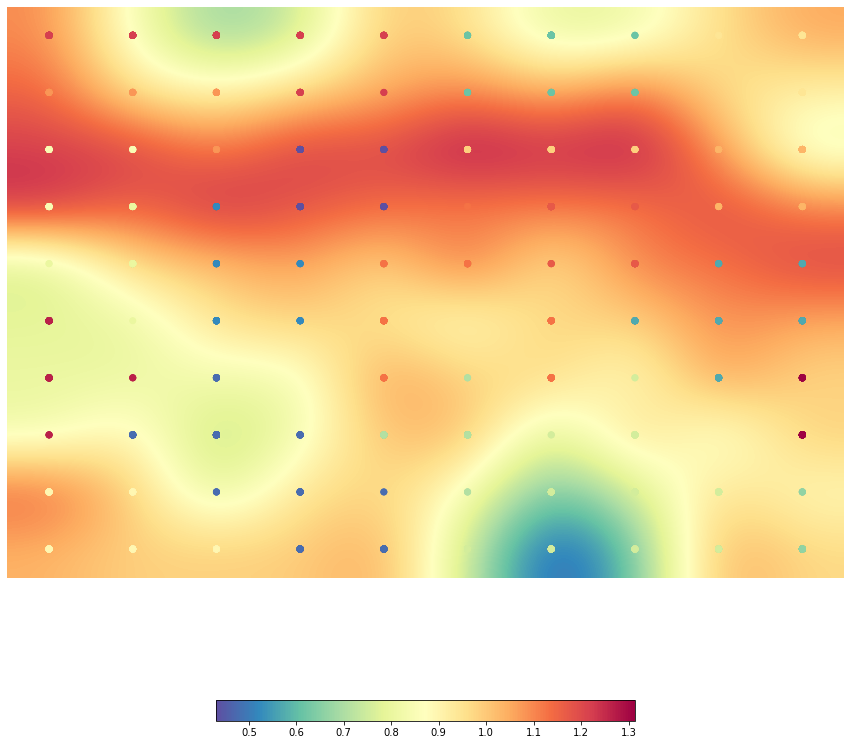

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [75]:
som_10.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

Το u-matrix του SOM που δημιουργήσαμε με διαστάσεις 10x10 και το οποίο εκπαιδεύσαμε με τις πρώτες 2000 ταινίες του dataset εμφανίζει μερικά ξεκάθαρα clusters αλλά και άλλα λιγότερα εμφανή. Παρατηρούμε λοιπόν τουλάχιστον 6 περιοχές με μπλέ, πράσινο ή έντονο κίτρινο χρώμα, μερικές από τις οποίες βρίσκονται κοντά μεταξύ τους (π.χ. οι δύο κιτρινοπράσινες περιοχές στο κάτω αριστερό μέρος του χάρτη) ή και άλλες που βρίσκονται πιο μακριά από τις υπόλοιπες (όπως η έντονη μπλε περιοχή κάτω δεξιά). Αυτό μπορεί να ερμηνευθεί αν θεωρήσουμε πως υπάρχουν τουλάχιστον 6 διαφορετικές κατηγορίες ταινιών στο dataset, μερικές εκ των οποίων είναι συγγενικές (π.χ. Action, Adventure) ενώ άλλες είναι πιο μακρινές (π.χ. Horror). 

Επαναλαμβάνουμε το clustering με την KMeans ώστε να μειώσουμε το πλήθος των clusters, αφού βλέπουμε πως στο u-matrix έχουμε περίπου 6 clusters αλλά ο KMeans έχει εντοπίσει 20, με αποτέλεσμα να εμφανίζει πολύ ειδικές υποκατηγορίες.

In [190]:
som_10.cluster(algorithm=KMeans(n_clusters=10))

In [192]:
with open('drive/MyDrive/som_10_10.dump', 'wb') as fid:
  pickle.dump(som_10, fid)

In [194]:
with open('drive/MyDrive/som_10_10.dump', 'rb') as fid:
  som_10 = pickle.load(fid)

In [196]:
cluster_info(som_10, 10, True)

k=10

Cluster map
[[6 6 6 6 6 4 4 2 2 2]
 [6 6 6 6 6 3 4 2 2 2]
 [6 6 6 7 7 0 0 1 2 2]
 [5 5 5 7 7 0 0 1 2 2]
 [5 5 5 7 7 0 0 1 9 9]
 [5 5 5 3 3 0 1 1 9 9]
 [5 3 3 3 3 4 1 1 9 9]
 [3 3 3 3 3 4 4 4 4 4]
 [8 8 3 3 3 4 4 4 4 4]
 [8 8 3 3 3 4 4 4 4 4]]

Clusters sorted by increasing number of neurons:
[[Cluster number]
[Number of neurons]]

[[ 8  7  9  0  1  2  5  6  3  4]
 [ 4  6  6  7  7 10 10 13 18 19]]


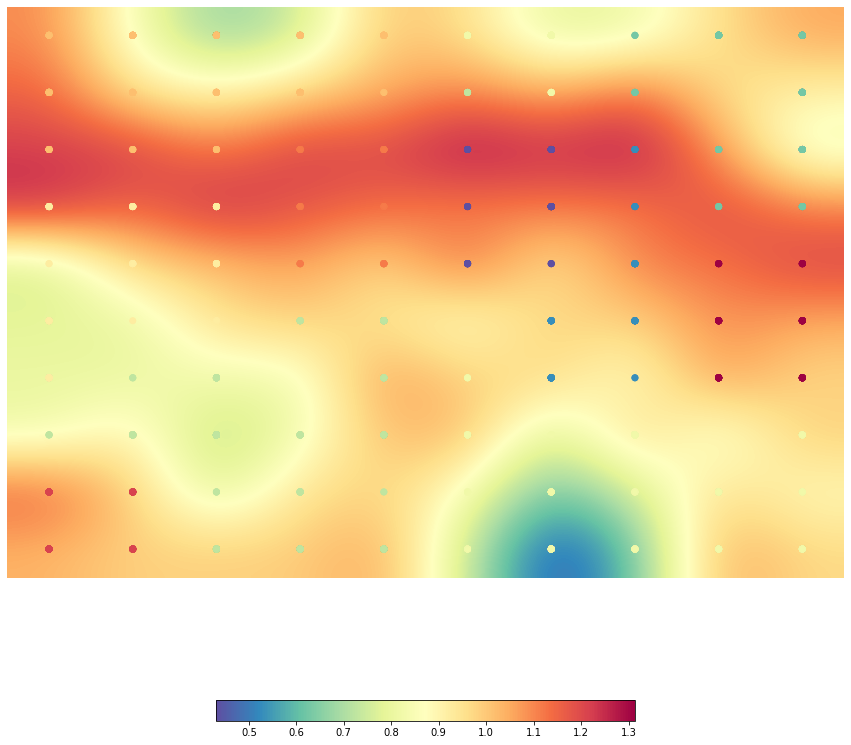

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [214]:
som_10.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [26]:
def print_cluster_movies_report(som, cluster_label):
  clusters = som.clusters
  args = []
  for i,j in np.argwhere(clusters==cluster_label):
    args.append((i,j))
  # args contains neuron coordinates with label==cluster_label
  
  bmus = som.bmus
  unique_bmus, indices = np.unique(bmus, return_inverse=True, axis=0)
  movie_ids = []
  for ind in indices:
    i,j = unique_bmus[ind]
    if (i,j) in args:
      movie_ids.append(ind)
  # movie_ids contains movies belonging in neuron contained in args
  
  all_cats = []
  total = len(movie_ids)
  for movie in movie_ids:
    new_cats = []
    cats = categories[movie][0].split(', ')
    for cat in cats:
      cat = cat.replace(' "', '"')
      new_cats.append(cat)
    all_cats.extend(np.unique(new_cats))
  # all_cats contains every category once for each movie containing it
  
  unique_cats, freqs = np.unique(all_cats, return_counts=True)
  sorted_inds = np.argsort(freqs)
  for i in sorted_inds:
    print("{} with {} occurancies and frequency {:.2f}%".format(unique_cats[i],
                                                                freqs[i],
                                                                freqs[i]/total*100))

Αφού υλοποιήσαμε τη συνάρτηση την δοκιμάζουμε στα clusters που εντοπίσαμε παραπάνω.

In [203]:
print_cluster_movies_report(som_10, 0)

"Musical" with 9 occurancies and frequency 9.47%
"Horror" with 13 occurancies and frequency 13.68%
"Adventure" with 25 occurancies and frequency 26.32%
"Action" with 33 occurancies and frequency 34.74%
"Action/Adventure" with 33 occurancies and frequency 34.74%
"Animation" with 33 occurancies and frequency 34.74%
"Black comedy" with 33 occurancies and frequency 34.74%
"Buddy film" with 33 occurancies and frequency 34.74%
"Comedy" with 33 occurancies and frequency 34.74%
"Family Film" with 33 occurancies and frequency 34.74%
"Fantasy Comedy" with 33 occurancies and frequency 34.74%
"Fantasy" with 33 occurancies and frequency 34.74%
"Mystery" with 33 occurancies and frequency 34.74%
"Parody" with 33 occurancies and frequency 34.74%
"Drama" with 40 occurancies and frequency 42.11%
"Crime Fiction" with 48 occurancies and frequency 50.53%


Οι ταινίες του cluster 0 ανήκουν στα είδη 'Crime Fiction', 'Drama'.

In [204]:
print_cluster_movies_report(som_10, 1)

"Comedy film" with 2 occurancies and frequency 1.15%
"Parody" with 3 occurancies and frequency 1.72%
"Mockumentary" with 3 occurancies and frequency 1.72%
"Media Satire" with 3 occurancies and frequency 1.72%
"Domestic Comedy" with 3 occurancies and frequency 1.72%
"Action" with 17 occurancies and frequency 9.77%
"Action/Adventure" with 17 occurancies and frequency 9.77%
"Crime Comedy" with 17 occurancies and frequency 9.77%
"Romance Film" with 17 occurancies and frequency 9.77%
"Indie" with 17 occurancies and frequency 9.77%
"Romantic comedy" with 20 occurancies and frequency 11.49%
"Musical" with 27 occurancies and frequency 15.52%
"Crime Fiction" with 43 occurancies and frequency 24.71%
"Comedy" with 47 occurancies and frequency 27.01%
"Family Film" with 65 occurancies and frequency 37.36%
"Fantasy" with 65 occurancies and frequency 37.36%
"Adventure" with 82 occurancies and frequency 47.13%
"Drama" with 169 occurancies and frequency 97.13%


Οι ταινίες του cluster 1 ανήκουν στα είδη 'Drama', 'Adventure', 'Fantasy'.

In [205]:
print_cluster_movies_report(som_10, 2)

"Horror" with 4 occurancies and frequency 1.78%
"Thriller" with 4 occurancies and frequency 1.78%
"Supernatural" with 4 occurancies and frequency 1.78%
"Short Film" with 4 occurancies and frequency 1.78%
"Romance Film" with 4 occurancies and frequency 1.78%
"Psychological thriller" with 4 occurancies and frequency 1.78%
"Disaster" with 4 occurancies and frequency 1.78%
"Mystery" with 4 occurancies and frequency 1.78%
"Comedy film" with 14 occurancies and frequency 6.22%
"World cinema" with 20 occurancies and frequency 8.89%
"Black-and-white" with 20 occurancies and frequency 8.89%
"Fantasy" with 24 occurancies and frequency 10.67%
"Japanese Movies" with 24 occurancies and frequency 10.67%
"Monster" with 24 occurancies and frequency 10.67%
"Cult" with 24 occurancies and frequency 10.67%
"Science Fiction" with 24 occurancies and frequency 10.67%
"Children's/Family" with 28 occurancies and frequency 12.44%
"Romantic comedy" with 33 occurancies and frequency 14.67%
"Feature film" with 35 o

Το cluster 2 περιέχει 'Drama', 'Comedy', 'Family film'.

In [206]:
print_cluster_movies_report(som_10, 3)

"Animation" with 3 occurancies and frequency 1.42%
"Pre-Code" with 6 occurancies and frequency 2.83%
"Musical" with 6 occurancies and frequency 2.83%
"Musical comedy" with 6 occurancies and frequency 2.83%
"World cinema" with 7 occurancies and frequency 3.30%
"Romantic comedy" with 7 occurancies and frequency 3.30%
"Propaganda film" with 7 occurancies and frequency 3.30%
"Disaster" with 7 occurancies and frequency 3.30%
"Short Film" with 8 occurancies and frequency 3.77%
"Docudrama" with 8 occurancies and frequency 3.77%
"Silent film" with 10 occurancies and frequency 4.72%
"Swashbuckler films" with 10 occurancies and frequency 4.72%
"Japanese Movies" with 13 occurancies and frequency 6.13%
"Adventure" with 16 occurancies and frequency 7.55%
"Action/Adventure" with 16 occurancies and frequency 7.55%
"Bollywood" with 18 occurancies and frequency 8.49%
"Action" with 23 occurancies and frequency 10.85%
"Melodrama" with 26 occurancies and frequency 12.26%
"Comedy" with 31 occurancies and f

Το cluster 3 'Biographical film', 'Drama', 'Black-and-white', 'Romance Film'.

In [207]:
print_cluster_movies_report(som_10, 4)

"Romantic comedy" with 2 occurancies and frequency 0.50%
"Musical" with 2 occurancies and frequency 0.50%
"Thriller" with 3 occurancies and frequency 0.75%
"Docudrama" with 18 occurancies and frequency 4.48%
"Marriage Drama" with 18 occurancies and frequency 4.48%
"Short Film" with 18 occurancies and frequency 4.48%
"Political drama" with 18 occurancies and frequency 4.48%
"Documentary" with 20 occurancies and frequency 4.98%
"Satire" with 21 occurancies and frequency 5.22%
"War film" with 21 occurancies and frequency 5.22%
"Black comedy" with 21 occurancies and frequency 5.22%
"Biopic [feature]" with 21 occurancies and frequency 5.22%
"Biography" with 21 occurancies and frequency 5.22%
"Biographical film" with 21 occurancies and frequency 5.22%
"Animation" with 21 occurancies and frequency 5.22%
"Comedy-drama" with 21 occurancies and frequency 5.22%
"Melodrama" with 22 occurancies and frequency 5.47%
"Horror" with 22 occurancies and frequency 5.47%
"Creature Film" with 22 occurancies 

Το cluster 4 'Drama'.

In [208]:
print_cluster_movies_report(som_10, 5)

"Boxing" with 2 occurancies and frequency 1.19%
"Sports" with 2 occurancies and frequency 1.19%
"Political drama" with 2 occurancies and frequency 1.19%
"Animation" with 6 occurancies and frequency 3.57%
"Short Film" with 6 occurancies and frequency 3.57%
"Biographical film" with 10 occurancies and frequency 5.95%
"Biography" with 10 occurancies and frequency 5.95%
"Period piece" with 10 occurancies and frequency 5.95%
"Bollywood" with 13 occurancies and frequency 7.74%
"Comedy-drama" with 13 occurancies and frequency 7.74%
"Musical" with 13 occurancies and frequency 7.74%
"Romantic comedy" with 13 occurancies and frequency 7.74%
"Filipino Movies" with 23 occurancies and frequency 13.69%
"Romantic drama" with 28 occurancies and frequency 16.67%
"Horror" with 31 occurancies and frequency 18.45%
"Comedy" with 35 occurancies and frequency 20.83%
"Action" with 59 occurancies and frequency 35.12%
"Chinese Movies" with 70 occurancies and frequency 41.67%
"World cinema" with 83 occurancies an

Το cluster 5 'Drama', 'Romance Film', 'World cinema'.

In [209]:
print_cluster_movies_report(som_10, 6)

"Coming of age" with 2 occurancies and frequency 0.68%
"Pre-Code" with 5 occurancies and frequency 1.70%
"Filipino Movies" with 6 occurancies and frequency 2.04%
"Spy" with 6 occurancies and frequency 2.04%
"Parody" with 6 occurancies and frequency 2.04%
"Martial Arts Film" with 6 occurancies and frequency 2.04%
"Television movie" with 10 occurancies and frequency 3.40%
"Period piece" with 10 occurancies and frequency 3.40%
"Docudrama" with 10 occurancies and frequency 3.40%
"Romantic drama" with 14 occurancies and frequency 4.76%
"Art film" with 14 occurancies and frequency 4.76%
"Japanese Movies" with 14 occurancies and frequency 4.76%
"Action" with 16 occurancies and frequency 5.44%
"Epic" with 18 occurancies and frequency 6.12%
"War film" with 18 occurancies and frequency 6.12%
"Historical Epic" with 18 occurancies and frequency 6.12%
"Indie" with 18 occurancies and frequency 6.12%
"Silent film" with 18 occurancies and frequency 6.12%
"Biopic [feature]" with 18 occurancies and freq

To cluster 6 'Comedy', 'Drama'.

In [211]:
print_cluster_movies_report(som_10, 7)

"Romantic drama" with 5 occurancies and frequency 6.85%
"Family-Oriented Adventure" with 9 occurancies and frequency 12.33%
"Animal Picture" with 9 occurancies and frequency 12.33%
"Period piece" with 9 occurancies and frequency 12.33%
"Family Drama" with 9 occurancies and frequency 12.33%
"Television movie" with 9 occurancies and frequency 12.33%
"Animation" with 10 occurancies and frequency 13.70%
"Holiday Film" with 10 occurancies and frequency 13.70%
"Romantic comedy" with 13 occurancies and frequency 17.81%
"Drama" with 14 occurancies and frequency 19.18%
"Musical" with 16 occurancies and frequency 21.92%
"Western" with 16 occurancies and frequency 21.92%
"Biography" with 16 occurancies and frequency 21.92%
"Children's/Family" with 19 occurancies and frequency 26.03%
"Family Film" with 19 occurancies and frequency 26.03%
"Adventure" with 19 occurancies and frequency 26.03%
"Indie" with 20 occurancies and frequency 27.40%
"Extreme Sports" with 20 occurancies and frequency 27.40%
"S

Το cluster 7 'Romance Film', 'Comedy'.

In [212]:
print_cluster_movies_report(som_10, 8)

"Comedy" with 32 occurancies and frequency 29.09%
"Indie" with 32 occurancies and frequency 29.09%
"Romantic comedy" with 32 occurancies and frequency 29.09%
"Silent film" with 38 occurancies and frequency 34.55%
"Biographical film" with 40 occurancies and frequency 36.36%
"Romance Film" with 72 occurancies and frequency 65.45%


Το cluster 8 'Romance Film'.

In [213]:
print_cluster_movies_report(som_10, 9)

"Comedy" with 2 occurancies and frequency 0.81%
"Crime Fiction" with 2 occurancies and frequency 0.81%
"Domestic Comedy" with 2 occurancies and frequency 0.81%
"Black-and-white" with 3 occurancies and frequency 1.21%
"Film noir" with 3 occurancies and frequency 1.21%
"Escape Film" with 14 occurancies and frequency 5.67%
"Thriller" with 14 occurancies and frequency 5.67%
"Horror" with 14 occurancies and frequency 5.67%
"Psychological thriller" with 14 occurancies and frequency 5.67%
"Science Fiction" with 14 occurancies and frequency 5.67%
"Film adaptation" with 15 occurancies and frequency 6.07%
"Period piece" with 15 occurancies and frequency 6.07%
"Romance Film" with 15 occurancies and frequency 6.07%
"World cinema" with 15 occurancies and frequency 6.07%
"Drama" with 18 occurancies and frequency 7.29%
"Silent film" with 37 occurancies and frequency 14.98%
"Documentary" with 176 occurancies and frequency 71.26%


Το cluster 9 'Documentary'.

Παρατηρούμε πως κοντινά clusters όπως αυτά φαίνονται στο u-matrix όπως τα 2,3,4 και 6 είναι και σημασιολογικά κοντά αφού όλα τους περιέχουν το είδος 'Drama', ενώ μακρινά clusters όπως το 1 με το 9 έχουν και μακρινά είδη, 'Adventure' και 'Documentary' αντίστοιχα.


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


Επαναλαμβάνουμε τη διαδικασία για μεγαλύτερο SOM διαστάσεων 20x20.

In [215]:
n_rows, n_cols = 20, 20
som_20 = somoclu.Somoclu(n_cols, n_rows)

In [216]:
%time som_20.train(final_set_2000, epochs=100)
with open('drive/MyDrive/som_20.dump', 'wb') as fid:
  pickle.dump(som_20, fid)

CPU times: user 41min 36s, sys: 13.3 s, total: 41min 50s
Wall time: 21min 26s


In [217]:
with open('drive/MyDrive/som_20.dump', 'rb') as fid:
  som_20 = pickle.load(fid)

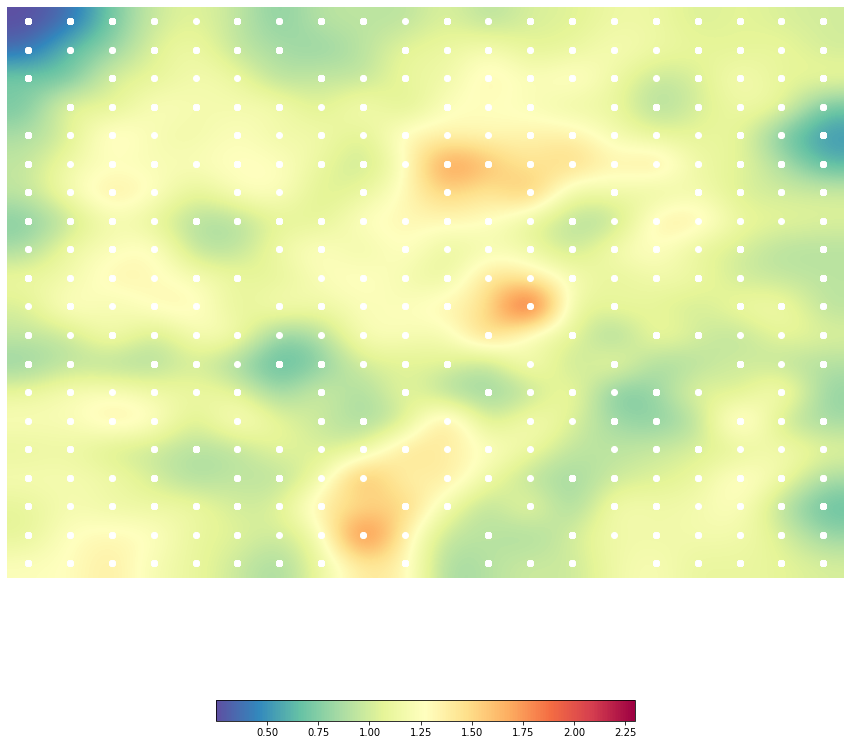

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [218]:
som_20.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

Από το u-matrix βλέπουμε πως σχηματίζονται 15 περιοχές, οπότε θα κάνουμε χρήση του αλγορίθμου KMeans με όρισμα 15 για να τις εντοπίσουμε.

In [233]:
som_20.cluster(algorithm=KMeans(n_clusters=15))

In [234]:
cluster_info(som_20, 15, True)

k=15

Cluster map
[[ 4  4  4  4  4  4  4  4  9  9  9  9  9  9  9 12 12  6  7  7]
 [ 4  4  4  4  4  4  4  4  9  9  9  9  9  9  9 12 12  6  0  0]
 [ 4  4  4  4  4  4  4  4  4  9  9  9  9  9  9 12 12 12  0  0]
 [ 4  4  4  4  4  4  4  4  4 12 12 12 12 12 12 12 12  0  0  0]
 [ 4  4  4  4  4  4  4  4  4 13 12 12 12 12 12 12  0  0  0  0]
 [ 4  4  4  4  4  4  4 13 13 13 12 12 12 12  0  0  0  0  0  0]
 [ 1  1  1  1 13 13 13 13 13 13 11 11 12 11  0  0  0  0  0  0]
 [ 1  1  1  1 13 13 13 13 13 11 11 11 11 11 11  0  0  0  0  0]
 [ 1  1  1  1 13 13 13 13 13 11 11 11 11 11 11  0  0  0  0  0]
 [ 1  1  1  2  2  8  8 13 11 11 11 11  0  0  0  0  6  0  0  0]
 [ 1  2  2  2  2  8  8  8  8 11 11 11  6  6  6  6  6 13 13  0]
 [ 2  2  2  2  2  8  8  8  8  8  8  4  6  6  6  6  6  6  0  5]
 [ 2  2  2  2  2  8  8  8  8  8  4  6  6  6  6  6  6  6  6  5]
 [ 2  2  2  2  2  8  8  8  8  8  6  6  6  6  6  6  6  6  6  6]
 [ 3  1  1 14 14  8 14  8  8  8  7  6  6  6  6  6  6  6  6  6]
 [14 14 14 14 14 14 14 14  8  8  7  7

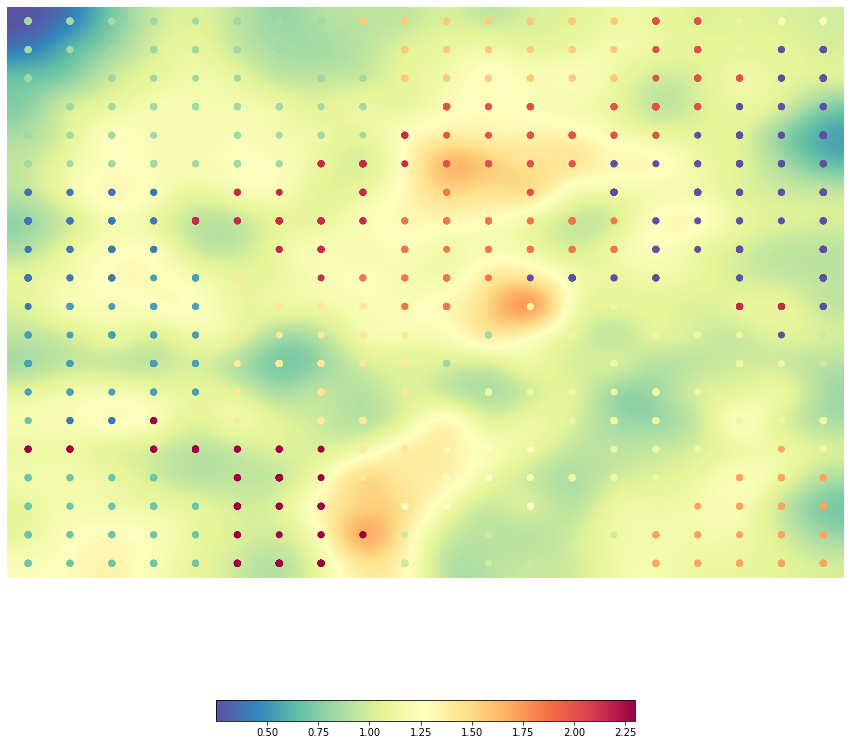

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [235]:
som_20.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [236]:
with open('drive/MyDrive/som_20.dump', 'wb') as fid:
  pickle.dump(som_20, fid)

In [223]:
with open('drive/MyDrive/som_20.dump', 'rb') as fid:
  som_20 = pickle.load(fid)

In [251]:
print_cluster_movies_report(som_20, 0)

"Suspense" with 1 occurancies and frequency 0.58%
"Mystery" with 1 occurancies and frequency 0.58%
"Mumblecore" with 2 occurancies and frequency 1.16%
"Musical" with 2 occurancies and frequency 1.16%
"Melodrama" with 3 occurancies and frequency 1.74%
"Slapstick" with 3 occurancies and frequency 1.74%
"Boxing" with 3 occurancies and frequency 1.74%
"Blaxploitation" with 3 occurancies and frequency 1.74%
"Crime Thriller" with 4 occurancies and frequency 2.33%
"Biography" with 4 occurancies and frequency 2.33%
"Parody" with 4 occurancies and frequency 2.33%
"Mockumentary" with 4 occurancies and frequency 2.33%
"Television movie" with 4 occurancies and frequency 2.33%
"Media Satire" with 4 occurancies and frequency 2.33%
"Period piece" with 4 occurancies and frequency 2.33%
"Swashbuckler films" with 4 occurancies and frequency 2.33%
"Domestic Comedy" with 4 occurancies and frequency 2.33%
"Bollywood" with 5 occurancies and frequency 2.91%
"Family Drama" with 6 occurancies and frequency 3.4

In [252]:
print_cluster_movies_report(som_20, 1)

"Biographical film" with 3 occurancies and frequency 2.97%
"Mystery" with 4 occurancies and frequency 3.96%
"Black comedy" with 4 occurancies and frequency 3.96%
"Political satire" with 5 occurancies and frequency 4.95%
"Japanese Movies" with 5 occurancies and frequency 4.95%
"Period piece" with 5 occurancies and frequency 4.95%
"Buddy film" with 5 occurancies and frequency 4.95%
"Political cinema" with 5 occurancies and frequency 4.95%
"Western" with 5 occurancies and frequency 4.95%
"Film adaptation" with 5 occurancies and frequency 4.95%
"Satire" with 5 occurancies and frequency 4.95%
"Adventure" with 5 occurancies and frequency 4.95%
"Suspense" with 5 occurancies and frequency 4.95%
"Romantic drama" with 7 occurancies and frequency 6.93%
"Silent film" with 7 occurancies and frequency 6.93%
"Indie" with 7 occurancies and frequency 6.93%
"Family Drama" with 7 occurancies and frequency 6.93%
"Psychological thriller" with 7 occurancies and frequency 6.93%
"Family Film" with 9 occuranci

In [253]:
print_cluster_movies_report(som_20, 2)

"Social problem film" with 2 occurancies and frequency 2.30%
"Sports" with 2 occurancies and frequency 2.30%
"Western" with 2 occurancies and frequency 2.30%
"Courtroom Drama" with 2 occurancies and frequency 2.30%
"Crime Fiction" with 3 occurancies and frequency 3.45%
"Crime Thriller" with 3 occurancies and frequency 3.45%
"Japanese Movies" with 3 occurancies and frequency 3.45%
"Political thriller" with 3 occurancies and frequency 3.45%
"Psychological thriller" with 4 occurancies and frequency 4.60%
"Cult" with 4 occurancies and frequency 4.60%
"Supernatural" with 4 occurancies and frequency 4.60%
"Comedy film" with 4 occurancies and frequency 4.60%
"Period piece" with 5 occurancies and frequency 5.75%
"Cold War" with 5 occurancies and frequency 5.75%
"Animal Picture" with 5 occurancies and frequency 5.75%
"Spy" with 5 occurancies and frequency 5.75%
"Film adaptation" with 5 occurancies and frequency 5.75%
"Parody" with 6 occurancies and frequency 6.90%
"Detective" with 6 occurancies

In [254]:
print_cluster_movies_report(som_20, 3)

"Action/Adventure" with 3 occurancies and frequency 1.91%
"Adventure" with 3 occurancies and frequency 1.91%
"Fantasy" with 3 occurancies and frequency 1.91%
"Psychological thriller" with 3 occurancies and frequency 1.91%
"Bollywood" with 3 occurancies and frequency 1.91%
"Stop motion" with 3 occurancies and frequency 1.91%
"Musical" with 3 occurancies and frequency 1.91%
"Comedy film" with 4 occurancies and frequency 2.55%
"Biopic [feature]" with 4 occurancies and frequency 2.55%
"Family Film" with 4 occurancies and frequency 2.55%
"Combat Films" with 4 occurancies and frequency 2.55%
"Television movie" with 4 occurancies and frequency 2.55%
"Romantic drama" with 5 occurancies and frequency 3.18%
"Romance Film" with 5 occurancies and frequency 3.18%
"Science Fiction" with 6 occurancies and frequency 3.82%
"Romantic comedy" with 6 occurancies and frequency 3.82%
"Film adaptation" with 6 occurancies and frequency 3.82%
"Christian film" with 6 occurancies and frequency 3.82%
"Period piec

In [255]:
print_cluster_movies_report(som_20, 4)

"Creature Film" with 1 occurancies and frequency 0.25%
"Revisionist Western" with 2 occurancies and frequency 0.50%
"Martial Arts Film" with 2 occurancies and frequency 0.50%
"Marriage Drama" with 2 occurancies and frequency 0.50%
"Filipino Movies" with 2 occurancies and frequency 0.50%
"Comedy-drama" with 2 occurancies and frequency 0.50%
"Spy" with 2 occurancies and frequency 0.50%
"Bollywood" with 2 occurancies and frequency 0.50%
"Heavenly Comedy" with 2 occurancies and frequency 0.50%
"Children's Fantasy" with 2 occurancies and frequency 0.50%
"Western" with 3 occurancies and frequency 0.74%
"Courtroom Drama" with 3 occurancies and frequency 0.74%
"Fantasy Comedy" with 4 occurancies and frequency 0.99%
"Film noir" with 4 occurancies and frequency 0.99%
"Buddy film" with 4 occurancies and frequency 0.99%
"Black comedy" with 4 occurancies and frequency 0.99%
"Holiday Film" with 4 occurancies and frequency 0.99%
"Animal Picture" with 4 occurancies and frequency 0.99%
"Family-Oriented

In [256]:
print_cluster_movies_report(som_20, 5)

"Black-and-white" with 1 occurancies and frequency 1.14%
"Chinese Movies" with 1 occurancies and frequency 1.14%
"Romantic comedy" with 1 occurancies and frequency 1.14%
"Propaganda film" with 1 occurancies and frequency 1.14%
"Political cinema" with 1 occurancies and frequency 1.14%
"Culture & Society" with 1 occurancies and frequency 1.14%
"Documentary" with 1 occurancies and frequency 1.14%
"Parody" with 1 occurancies and frequency 1.14%
"War film" with 1 occurancies and frequency 1.14%
"Musical" with 3 occurancies and frequency 3.41%
"Thriller" with 5 occurancies and frequency 5.68%
"World cinema" with 13 occurancies and frequency 14.77%
"Short Film" with 14 occurancies and frequency 15.91%
"Family Film" with 14 occurancies and frequency 15.91%
"Animation" with 14 occurancies and frequency 15.91%
"Crime Fiction" with 20 occurancies and frequency 22.73%
"Comedy film" with 20 occurancies and frequency 22.73%
"Action" with 21 occurancies and frequency 23.86%
"Biography" with 23 occura

In [257]:
print_cluster_movies_report(som_20, 6)

"Zombie Film" with 1 occurancies and frequency 0.46%
"Science fiction Western" with 1 occurancies and frequency 0.46%
"Science Fiction" with 1 occurancies and frequency 0.46%
"Satire" with 1 occurancies and frequency 0.46%
"Monster movie" with 1 occurancies and frequency 0.46%
"Comedy-drama" with 1 occurancies and frequency 0.46%
"Martial Arts Film" with 1 occurancies and frequency 0.46%
"Crime Drama" with 1 occurancies and frequency 0.46%
"Docudrama" with 1 occurancies and frequency 0.46%
"Teen" with 2 occurancies and frequency 0.92%
"Parody" with 2 occurancies and frequency 0.92%
"Children's Fantasy" with 2 occurancies and frequency 0.92%
"Comedy film" with 2 occurancies and frequency 0.92%
"Children's/Family" with 3 occurancies and frequency 1.38%
"Fantasy Comedy" with 4 occurancies and frequency 1.84%
"Indie" with 4 occurancies and frequency 1.84%
"Animation" with 4 occurancies and frequency 1.84%
"Romantic drama" with 5 occurancies and frequency 2.30%
"Mystery" with 5 occurancies 

In [258]:
print_cluster_movies_report(som_20, 7)

"Comedy" with 2 occurancies and frequency 2.25%
"Adventure" with 5 occurancies and frequency 5.62%
"Horror" with 5 occurancies and frequency 5.62%
"Children's/Family" with 6 occurancies and frequency 6.74%
"Monster" with 7 occurancies and frequency 7.87%
"Cult" with 7 occurancies and frequency 7.87%
"Science Fiction" with 7 occurancies and frequency 7.87%
"Thriller" with 9 occurancies and frequency 10.11%
"Caper story" with 9 occurancies and frequency 10.11%
"Heist" with 9 occurancies and frequency 10.11%
"Crime Thriller" with 9 occurancies and frequency 10.11%
"War film" with 9 occurancies and frequency 10.11%
"Film noir" with 9 occurancies and frequency 10.11%
"Gangster Film" with 9 occurancies and frequency 10.11%
"Romance Film" with 10 occurancies and frequency 11.24%
"Bollywood" with 10 occurancies and frequency 11.24%
"Musical" with 10 occurancies and frequency 11.24%
"Martial Arts Film" with 11 occurancies and frequency 12.36%
"Action Thrillers" with 11 occurancies and frequency

In [259]:
print_cluster_movies_report(som_20, 8)

"Melodrama" with 1 occurancies and frequency 1.14%
"Americana" with 1 occurancies and frequency 1.14%
"Animation" with 1 occurancies and frequency 1.14%
"Pre-Code" with 1 occurancies and frequency 1.14%
"Family Film" with 1 occurancies and frequency 1.14%
"Crime Drama" with 1 occurancies and frequency 1.14%
"History" with 1 occurancies and frequency 1.14%
"Documentary" with 1 occurancies and frequency 1.14%
"Road movie" with 1 occurancies and frequency 1.14%
"Crime Thriller" with 2 occurancies and frequency 2.27%
"Romantic drama" with 2 occurancies and frequency 2.27%
"Film noir" with 3 occurancies and frequency 3.41%
"Family Drama" with 3 occurancies and frequency 3.41%
"Japanese Movies" with 3 occurancies and frequency 3.41%
"Crime Fiction" with 3 occurancies and frequency 3.41%
"Science Fiction" with 4 occurancies and frequency 4.55%
"Short Film" with 4 occurancies and frequency 4.55%
"Action/Adventure" with 4 occurancies and frequency 4.55%
"Western" with 4 occurancies and frequenc

In [260]:
print_cluster_movies_report(som_20, 9)

"Feature film" with 1 occurancies and frequency 1.32%
"Romantic comedy" with 1 occurancies and frequency 1.32%
"War film" with 1 occurancies and frequency 1.32%
"Silent film" with 1 occurancies and frequency 1.32%
"Pre-Code" with 2 occurancies and frequency 2.63%
"Fantasy" with 2 occurancies and frequency 2.63%
"Filipino Movies" with 3 occurancies and frequency 3.95%
"Romantic drama" with 3 occurancies and frequency 3.95%
"Domestic Comedy" with 4 occurancies and frequency 5.26%
"Adventure" with 4 occurancies and frequency 5.26%
"Animation" with 5 occurancies and frequency 6.58%
"Family Film" with 6 occurancies and frequency 7.89%
"Biography" with 6 occurancies and frequency 7.89%
"Biographical film" with 6 occurancies and frequency 7.89%
"Horror" with 6 occurancies and frequency 7.89%
"Short Film" with 7 occurancies and frequency 9.21%
"Crime Fiction" with 7 occurancies and frequency 9.21%
"Disaster" with 8 occurancies and frequency 10.53%
"Psychological thriller" with 8 occurancies an

In [261]:
print_cluster_movies_report(som_20, 10)

"Monster" with 1 occurancies and frequency 0.72%
"Sci-Fi Adventure" with 1 occurancies and frequency 0.72%
"Comedy-drama" with 1 occurancies and frequency 0.72%
"Creature Film" with 3 occurancies and frequency 2.17%
"War film" with 3 occurancies and frequency 2.17%
"Sci-Fi Horror" with 3 occurancies and frequency 2.17%
"Cult" with 3 occurancies and frequency 2.17%
"Mockumentary" with 5 occurancies and frequency 3.62%
"History" with 5 occurancies and frequency 3.62%
"Crime Drama" with 5 occurancies and frequency 3.62%
"Medical fiction" with 5 occurancies and frequency 3.62%
"Coming of age" with 5 occurancies and frequency 3.62%
"Parody" with 6 occurancies and frequency 4.35%
"Crime Fiction" with 8 occurancies and frequency 5.80%
"Children's/Family" with 8 occurancies and frequency 5.80%
"Mystery" with 8 occurancies and frequency 5.80%
"Animated Musical" with 8 occurancies and frequency 5.80%
"Film noir" with 8 occurancies and frequency 5.80%
"Adventure" with 9 occurancies and frequency 

In [262]:
print_cluster_movies_report(som_20, 11)

"Slapstick" with 2 occurancies and frequency 2.35%
"Film adaptation" with 2 occurancies and frequency 2.35%
"Monster" with 2 occurancies and frequency 2.35%
"B-movie" with 2 occurancies and frequency 2.35%
"Natural horror films" with 2 occurancies and frequency 2.35%
"Science Fiction" with 2 occurancies and frequency 2.35%
"Cult" with 2 occurancies and frequency 2.35%
"Creature Film" with 2 occurancies and frequency 2.35%
"Propaganda film" with 2 occurancies and frequency 2.35%
"Comedy-drama" with 3 occurancies and frequency 3.53%
"Documentary" with 3 occurancies and frequency 3.53%
"Crime Fiction" with 3 occurancies and frequency 3.53%
"Gross-out film" with 3 occurancies and frequency 3.53%
"Comedy of manners" with 3 occurancies and frequency 3.53%
"Comedy film" with 3 occurancies and frequency 3.53%
"Romantic comedy" with 3 occurancies and frequency 3.53%
"Sex comedy" with 3 occurancies and frequency 3.53%
"Gross out" with 3 occurancies and frequency 3.53%
"Costume Horror" with 5 occ

In [264]:
print_cluster_movies_report(som_20, 12)

"Horror Comedy" with 1 occurancies and frequency 0.90%
"Teen" with 1 occurancies and frequency 0.90%
"B-movie" with 1 occurancies and frequency 0.90%
"Horror" with 1 occurancies and frequency 0.90%
"Comedy-drama" with 2 occurancies and frequency 1.80%
"Satire" with 2 occurancies and frequency 1.80%
"Black comedy" with 2 occurancies and frequency 1.80%
"Political drama" with 2 occurancies and frequency 1.80%
"Disaster" with 3 occurancies and frequency 2.70%
"Pre-Code" with 3 occurancies and frequency 2.70%
"Docudrama" with 3 occurancies and frequency 2.70%
"Propaganda film" with 3 occurancies and frequency 2.70%
"Comedy film" with 3 occurancies and frequency 2.70%
"Documentary" with 3 occurancies and frequency 2.70%
"Extreme Sports" with 4 occurancies and frequency 3.60%
"Period piece" with 4 occurancies and frequency 3.60%
"Musical" with 4 occurancies and frequency 3.60%
"Action" with 4 occurancies and frequency 3.60%
"Coming of age" with 4 occurancies and frequency 3.60%
"Sports" with

In [265]:
print_cluster_movies_report(som_20, 13)

"Satire" with 1 occurancies and frequency 1.32%
"Comedy film" with 1 occurancies and frequency 1.32%
"Action/Adventure" with 2 occurancies and frequency 2.63%
"Crime Fiction" with 2 occurancies and frequency 2.63%
"Indie" with 3 occurancies and frequency 3.95%
"War film" with 3 occurancies and frequency 3.95%
"Suspense" with 3 occurancies and frequency 3.95%
"Science Fiction" with 3 occurancies and frequency 3.95%
"Historical fiction" with 3 occurancies and frequency 3.95%
"Slasher" with 3 occurancies and frequency 3.95%
"Family Drama" with 5 occurancies and frequency 6.58%
"Romantic comedy" with 5 occurancies and frequency 6.58%
"Romantic drama" with 5 occurancies and frequency 6.58%
"Period piece" with 5 occurancies and frequency 6.58%
"Sports" with 5 occurancies and frequency 6.58%
"Fairy tale" with 8 occurancies and frequency 10.53%
"Children's Fantasy" with 8 occurancies and frequency 10.53%
"Black-and-white" with 8 occurancies and frequency 10.53%
"Fantasy Comedy" with 8 occuranc

In [266]:
print_cluster_movies_report(som_20, 14)

"Spy" with 1 occurancies and frequency 0.90%
"Political thriller" with 1 occurancies and frequency 0.90%
"Animated cartoon" with 1 occurancies and frequency 0.90%
"Dystopia" with 1 occurancies and frequency 0.90%
"Legal drama" with 2 occurancies and frequency 1.80%
"Courtroom Drama" with 2 occurancies and frequency 1.80%
"Courtroom Comedy" with 2 occurancies and frequency 1.80%
"Zombie Film" with 2 occurancies and frequency 1.80%
"Action/Adventure" with 2 occurancies and frequency 1.80%
"Comedy Thriller" with 2 occurancies and frequency 1.80%
"Silent film" with 3 occurancies and frequency 2.70%
"Family Film" with 3 occurancies and frequency 2.70%
"Romantic comedy" with 4 occurancies and frequency 3.60%
"Chinese Movies" with 5 occurancies and frequency 4.50%
"Teen" with 5 occurancies and frequency 4.50%
"Comedy film" with 5 occurancies and frequency 4.50%
"Indie" with 5 occurancies and frequency 4.50%
"Slice of life story" with 7 occurancies and frequency 6.31%
"Music" with 7 occurancie

Παρατηρούμε πως οι κατηγορίες οι οποίες έχουμε μεγάλο ποσοστό συμμετοχής (κοντά στο 50%) αντιστοιχούν σε clusters τα οποία είναι πιο συγκεντρωμένα (μπλε/πράσινες περιοχές), ενώ τα clusters στα οποία η πιο συχνή κατηγορία έπαιρνε τιμές κοντά στο 30% αντιστοιχούν σε σημεία του SOM τα οποία δεν εμφανίζουν έντονη συσταδοποίηση. Επιπλέον, όπως ήταν αναμενόμενο clusters τα οποία μοιράζονται κατηγορίες (π.χ. το 12 με το 9) βρίσκονται πιο κοντά από άλλα με διαφορετικές κατηγορίες (π.χ. το 14 με το 5).

Από τα παραπάνω πειράματα καταλήγουμε στο συμπέρασμα πως αυξάνοντας το μέγεθος του SOM χωρίς να αυξάνουμε το πλήθος των ταινιών εμφανίζουμε περισσότερες περιοχές, το οποίο ρίχνει την ποιότητά τους αφού οι ξεχωριστές περιοχές δεν είναι απαραίτητα αρκετά ξένες ώστε να μην ανήκουν σε κοινή κατηγορία. Σε μικρά μεγέθη SOM οι περιοχές είναι πιο ευδιάκριτες και εμφανίζουν μεγαλύτερη συνάφεια, έχουν όμως το μειονέκτημα πως δεν διακρίνουν όλες τις διαφορετικές περιοχές.



## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM και δεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


Στο σημείο αυτό δημιουργούμε ένα 10x10 και ένα 20x20 SOM τα οποία και εκπαιδεύουμε στο πλήρες dataset.

### SOM 10x10 full dataset

In [267]:
n_rows, n_cols = 10, 10
som_10_full = somoclu.Somoclu(n_cols, n_rows)

In [268]:
%time som_10_full.train(final_set, epochs=100)
with open('drive/MyDrive/som_10_full.dump', 'wb') as fid:
  pickle.dump(som_10_full, fid)

CPU times: user 25min 38s, sys: 7.73 s, total: 25min 45s
Wall time: 13min 46s


In [18]:
with open('drive/MyDrive/som_10_full.dump', 'rb') as fid:
  som_10_full = pickle.load(fid)

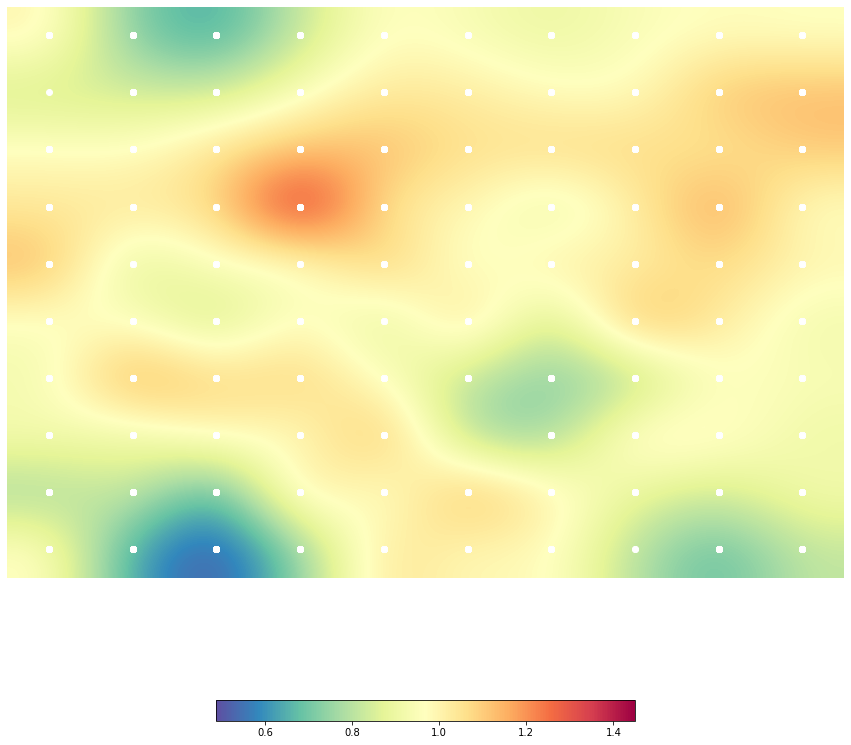

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [19]:
som_10_full.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

Από το u-matrix για τον 10x10 SOM μπορούμε να εντοπίσουμε 4 μπλε-πράσινες περιοχές που βρίσκονται κοντά οι νευρώνες, το οποίο και θα οδηγήσει σε αρκετά γενικές κατηγορίες ταινιών αν κάνουμε χρήση του KMeans με k κοντά σε αυτό. Δοκιμάζουμε να κάνουμε clustering για k=6.

In [35]:
som_10_full.cluster(algorithm=KMeans(n_clusters=6))

In [49]:
cluster_info(som_10_full, 6, True)

k=6

Cluster map
[[5 5 5 5 5 4 4 4 2 2]
 [5 5 5 5 4 4 4 4 2 2]
 [5 5 5 5 4 4 3 3 2 2]
 [1 1 1 0 0 3 3 3 3 3]
 [1 1 1 0 0 3 3 3 3 3]
 [1 1 1 0 0 0 0 3 2 2]
 [1 1 1 0 0 0 0 0 2 2]
 [4 4 4 4 0 0 0 0 0 2]
 [4 4 4 4 0 0 0 0 0 0]
 [4 4 4 4 0 0 0 0 0 0]]

Clusters sorted by increasing number of neurons:
[[Cluster number]
[Number of neurons]]

[[ 2  1  3  5  4  0]
 [11 12 13 13 21 30]]


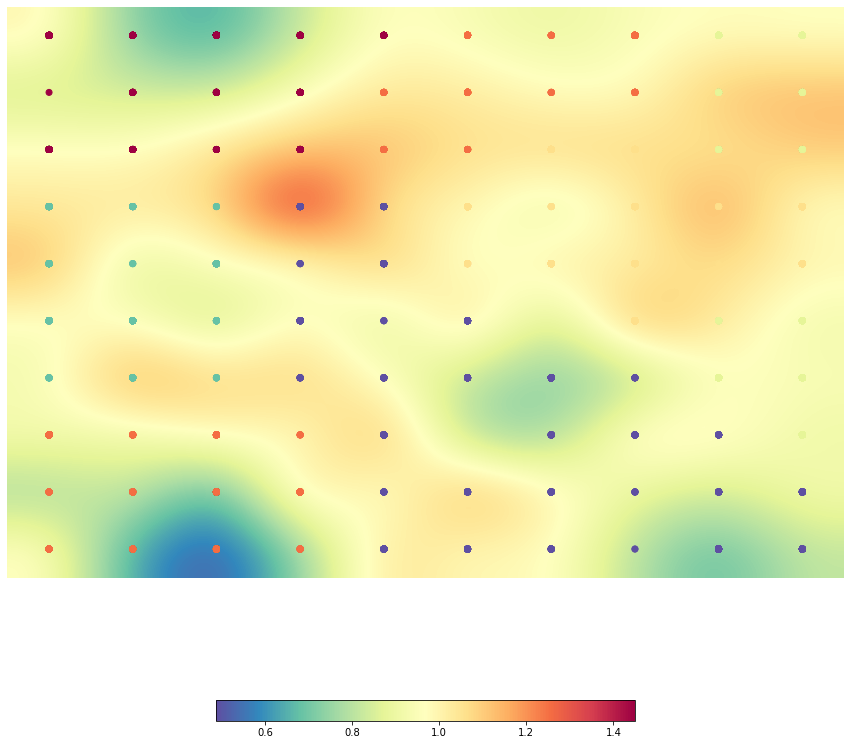

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [48]:
som_10_full.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [39]:
with open('drive/MyDrive/som_10_full.dump', 'wb') as fid:
  pickle.dump(som_10_full, fid)

In [40]:
with open('drive/MyDrive/som_10_full.dump', 'rb') as fid:
  som_10_full = pickle.load(fid)

Μελετάμε τις κατηγορίες που περιέχει κάθε ένα από τα 6 clusters.

In [41]:
print_cluster_movies_report(som_10_full, 0)

"Melodrama" with 7 occurancies and frequency 0.49%
"Horror" with 7 occurancies and frequency 0.49%
"Creature Film" with 7 occurancies and frequency 0.49%
"Musical" with 9 occurancies and frequency 0.63%
"Film adaptation" with 17 occurancies and frequency 1.20%
"Comedy-drama" with 17 occurancies and frequency 1.20%
"Satire" with 17 occurancies and frequency 1.20%
"Mockumentary" with 18 occurancies and frequency 1.27%
"Media Satire" with 18 occurancies and frequency 1.27%
"Domestic Comedy" with 18 occurancies and frequency 1.27%
"Coming of age" with 23 occurancies and frequency 1.62%
"Silent film" with 31 occurancies and frequency 2.18%
"Comedy film" with 36 occurancies and frequency 2.53%
"Period piece" with 39 occurancies and frequency 2.74%
"Children's/Family" with 39 occurancies and frequency 2.74%
"Television movie" with 39 occurancies and frequency 2.74%
"Animal Picture" with 39 occurancies and frequency 2.74%
"Family-Oriented Adventure" with 39 occurancies and frequency 2.74%
"Fam

Με αυτό το label έχουν χαρακτηριστεί οι ταινίες που ανήκουν στην κατηγορία Drama.

In [43]:
print_cluster_movies_report(som_10_full, 1)

"Action/Adventure" with 8 occurancies and frequency 1.69%
"Adventure" with 8 occurancies and frequency 1.69%
"Black-and-white" with 8 occurancies and frequency 1.69%
"World cinema" with 18 occurancies and frequency 3.81%
"Chinese Movies" with 18 occurancies and frequency 3.81%
"Action" with 20 occurancies and frequency 4.24%
"Romantic comedy" with 21 occurancies and frequency 4.45%
"Sports" with 31 occurancies and frequency 6.57%
"Political drama" with 31 occurancies and frequency 6.57%
"Boxing" with 31 occurancies and frequency 6.57%
"Filipino Movies" with 38 occurancies and frequency 8.05%
"Melodrama" with 47 occurancies and frequency 9.96%
"Romantic drama" with 63 occurancies and frequency 13.35%
"Animation" with 75 occurancies and frequency 15.89%
"Short Film" with 75 occurancies and frequency 15.89%
"Horror" with 85 occurancies and frequency 18.01%
"Comedy" with 123 occurancies and frequency 26.06%
"Romance Film" with 131 occurancies and frequency 27.75%
"Drama" with 283 occuranci

Το label 1 περιέχει επίσης κυρίως ταινίες Drama, για αυτό βρίσκεται σε πολύ κοντινή απόσταση με το cluster με label 0.

In [44]:
print_cluster_movies_report(som_10_full, 2)

"Animation" with 2 occurancies and frequency 0.22%
"Biographical film" with 2 occurancies and frequency 0.22%
"Biography" with 2 occurancies and frequency 0.22%
"Biopic [feature]" with 2 occurancies and frequency 0.22%
"Coming of age" with 2 occurancies and frequency 0.22%
"Black-and-white" with 15 occurancies and frequency 1.67%
"Horror" with 39 occurancies and frequency 4.34%
"Escape Film" with 39 occurancies and frequency 4.34%
"Fantasy" with 40 occurancies and frequency 4.45%
"Monster" with 40 occurancies and frequency 4.45%
"Japanese Movies" with 40 occurancies and frequency 4.45%
"Cult" with 40 occurancies and frequency 4.45%
"Documentary" with 48 occurancies and frequency 5.35%
"Comedy" with 55 occurancies and frequency 6.12%
"Chinese Movies" with 55 occurancies and frequency 6.12%
"Supernatural" with 71 occurancies and frequency 7.91%
"Disaster" with 71 occurancies and frequency 7.91%
"Mystery" with 71 occurancies and frequency 7.91%
"Film adaptation" with 72 occurancies and fr

Οι ταινίες με label 2 ανήκουν σε είδη όπως Action και War film και στο U-matrix φαίνεται να απέχουν από τα υπόλοιπα clusters.

In [45]:
print_cluster_movies_report(som_10_full, 3)

"Horror" with 4 occurancies and frequency 0.93%
"Comedy film" with 7 occurancies and frequency 1.62%
"Silent film" with 12 occurancies and frequency 2.78%
"Action" with 13 occurancies and frequency 3.01%
"Action/Adventure" with 13 occurancies and frequency 3.01%
"Indie" with 13 occurancies and frequency 3.01%
"Crime Comedy" with 13 occurancies and frequency 3.01%
"Romantic drama" with 19 occurancies and frequency 4.40%
"Comedy-drama" with 19 occurancies and frequency 4.40%
"World cinema" with 19 occurancies and frequency 4.40%
"Bollywood" with 19 occurancies and frequency 4.40%
"Romance Film" with 32 occurancies and frequency 7.41%
"Romantic comedy" with 32 occurancies and frequency 7.41%
"Animation" with 49 occurancies and frequency 11.34%
"Fantasy" with 59 occurancies and frequency 13.66%
"Adventure" with 72 occurancies and frequency 16.67%
"Biography" with 80 occurancies and frequency 18.52%
"Biographical film" with 80 occurancies and frequency 18.52%
"Period piece" with 80 occuranc

Οι ταινίες του label 3 ανήκουν κυρίως στην κατηγορία Drama με υποκατηγορίες όπως Comedy, Musical και Family Film, για αυτό και είναι κοντά με τα labels 0 και 1.

In [46]:
print_cluster_movies_report(som_10_full, 4)

"Pre-Code" with 21 occurancies and frequency 1.96%
"Musical" with 21 occurancies and frequency 1.96%
"Musical comedy" with 21 occurancies and frequency 1.96%
"World cinema" with 25 occurancies and frequency 2.33%
"Propaganda film" with 25 occurancies and frequency 2.33%
"Disaster" with 25 occurancies and frequency 2.33%
"Swashbuckler films" with 32 occurancies and frequency 2.99%
"Thriller" with 35 occurancies and frequency 3.27%
"Documentary" with 42 occurancies and frequency 3.92%
"Japanese Movies" with 45 occurancies and frequency 4.20%
"Biographical film" with 54 occurancies and frequency 5.04%
"Docudrama" with 67 occurancies and frequency 6.26%
"Black-and-white" with 78 occurancies and frequency 7.28%
"Road movie" with 92 occurancies and frequency 8.59%
"Period piece" with 92 occurancies and frequency 8.59%
"Romantic comedy" with 94 occurancies and frequency 8.78%
"Family Film" with 101 occurancies and frequency 9.43%
"Holiday Film" with 101 occurancies and frequency 9.43%
"Silent

Το label 4 περιέχει κατηγορίες όπως Short Film, Comedy και Animation και απέχει από τα τριγύρω clusters.

In [47]:
print_cluster_movies_report(som_10_full, 5)

"Fantasy" with 1 occurancies and frequency 0.14%
"Musical" with 5 occurancies and frequency 0.71%
"Biography" with 5 occurancies and frequency 0.71%
"Western" with 5 occurancies and frequency 0.71%
"Parody" with 18 occurancies and frequency 2.55%
"Martial Arts Film" with 18 occurancies and frequency 2.55%
"Filipino Movies" with 18 occurancies and frequency 2.55%
"Spy" with 18 occurancies and frequency 2.55%
"Period piece" with 20 occurancies and frequency 2.83%
"Television movie" with 20 occurancies and frequency 2.83%
"Docudrama" with 20 occurancies and frequency 2.83%
"Epic" with 32 occurancies and frequency 4.53%
"War film" with 32 occurancies and frequency 4.53%
"Historical Epic" with 32 occurancies and frequency 4.53%
"Biopic [feature]" with 32 occurancies and frequency 4.53%
"Biographical film" with 32 occurancies and frequency 4.53%
"Action" with 38 occurancies and frequency 5.38%
"Coming of age" with 39 occurancies and frequency 5.52%
"Short Film" with 43 occurancies and freque

Το τελευταίο label περιέχει Comedy και Romance Film ταινίες και επειδή δεν βρίσκεται κοντά με τις υπόλοιπες κατηγορίες παρατηρούμε πως διαχωρίζεται από τα άλλα clusters στο U-matrix με μια κίτρινη περιοχή, ενώ το ίδιο παρουσιάζει μικρές αποστάσεις ανάμεσα στους νευρώνες αφού έχει χρώμα πράσινο.

### SOM 20x20 full dataset

In [270]:
n_rows, n_cols = 20, 20
som_20_full = somoclu.Somoclu(n_cols, n_rows)

In [271]:
%time som_20_full.train(final_set, epochs=100)
with open('drive/MyDrive/som_20_full.dump', 'wb') as fid:
  pickle.dump(som_20_full, fid)

CPU times: user 1h 43min 50s, sys: 31.2 s, total: 1h 44min 21s
Wall time: 53min 19s


In [20]:
with open('drive/MyDrive/som_20_full.dump', 'rb') as fid:
  som_20_full = pickle.load(fid)

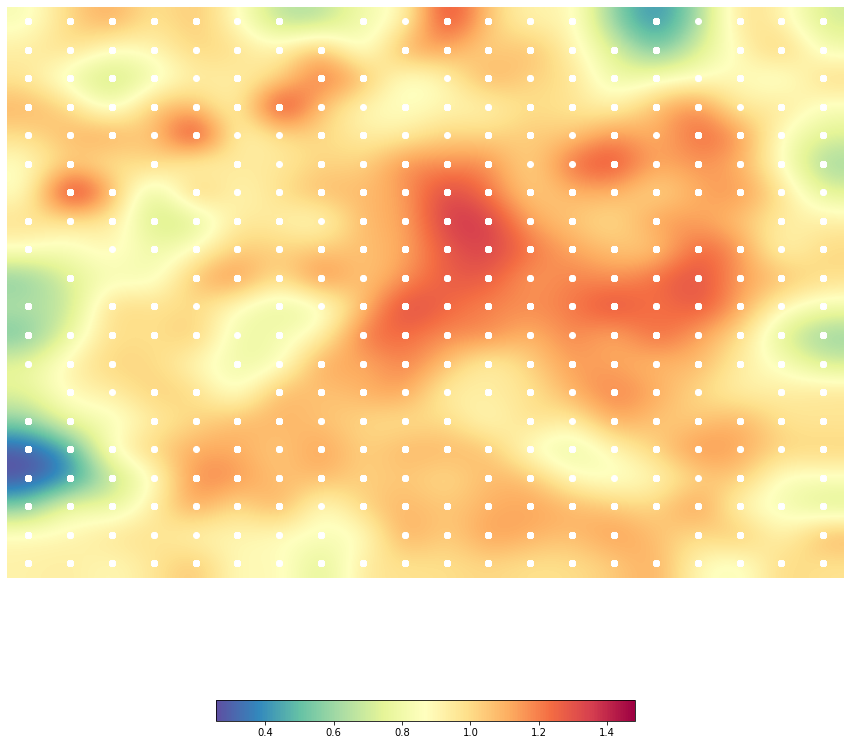

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [50]:
som_20_full.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

Στο U-matrix για τον 20x20 χάρτη παρατηρούμε πως εμφανίζονται περισσότερες περιοχές με πιο μεγάλες μεταξύ τους αποστάσεις. Οι περιοχές διαφορετικών χρωμάτων που μπορούμε να δούμε απλά παρατηρώντας το U-matrix είναι περίπου 13, τον οποίο αριθμό θα χρησιμοποιήσουμε και για το clustering στον αλγόριθμο KMeans.

In [51]:
som_20_full.cluster(algorithm=KMeans(n_clusters=13))

In [52]:
cluster_info(som_20_full, 13, True)

k=13

Cluster map
[[ 2  2  2  2  2  3  3  3  6  6  3 11 11 11 11 11 11 11 11 11]
 [ 2  2  2  2  2  3  3  3  6  6 11 11 11 11 11 11 11 11 11 11]
 [ 2  2  2  2  3  3  3  6  6  6  6  6 11 11 11 11 11 11  8  8]
 [ 2  2  2  2  3  3  3  3  6  6  6  6 11 11 11 11 11 11  8  8]
 [ 3  3  2  3  3  3  3  3  6  6  6 12 12 11 11 11 11 11  8  8]
 [ 3  3  3  3  3  3  3  3 12 12 12 12 12 11 11 11 11 11  8  8]
 [ 3  3  3  3  3  3  3  3  3 12 12 12 12 12 11 11 11  8  8  8]
 [ 3  3  3  3  3  3  3  3 12 12 12 12 12  0 11 11 11  8  8  8]
 [ 3  3  3  3  3  3  3  0  0  0  0  0  0  0  5  5  5  8  8  8]
 [ 3  3  3  3  3  5  5  0  0  0  0  0  0  5  5  5  5  8  8  8]
 [ 9  3  3  3  3  5  5  0  0  0  0  0  5  5  5  5  5  7  7  7]
 [ 9  9  9  9  9  5  5  5  0  0 10 10 10 10  5  5  7  7  7  7]
 [ 9  9  9  9  5  5  5 10 10 10 10 10 10 10 10 10  7  7  7  7]
 [ 9  9  9  9  5  5  5 10 10 10 10 10 10 10 10 10  7  7  7  7]
 [ 9  9  9  9  5  5  5 10 10 10 10 10 10  4  4  7  7  7  7  7]
 [ 9  9  9  9  5  0  5  5 10 10 10  4

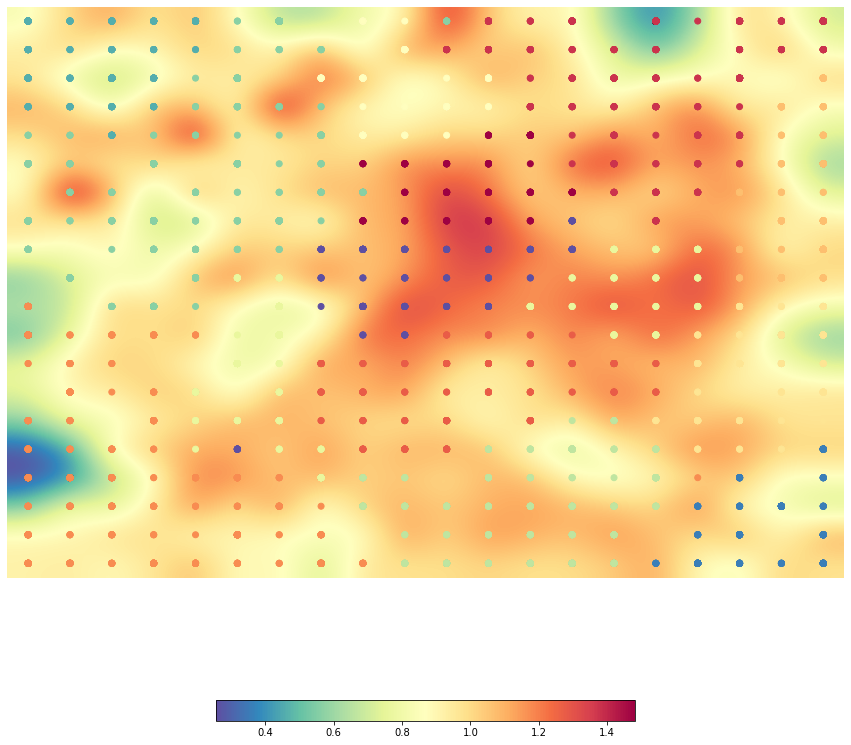

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [53]:
som_20_full.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [54]:
with open('drive/MyDrive/som_20_full.dump', 'wb') as fid:
  pickle.dump(som_20_full, fid)

In [55]:
with open('drive/MyDrive/som_20_full.dump', 'rb') as fid:
  som_20_full = pickle.load(fid)

Παρακάτω εμφανίζονται τα στατιστικά για κάθε ένα από τα labels.

In [56]:
print_cluster_movies_report(som_20_full, 0)

"Gross out" with 2 occurancies and frequency 1.23%
"Sex comedy" with 2 occurancies and frequency 1.23%
"Gross-out film" with 2 occurancies and frequency 1.23%
"History" with 3 occurancies and frequency 1.84%
"Propaganda film" with 4 occurancies and frequency 2.45%
"Comedy-drama" with 4 occurancies and frequency 2.45%
"Comedy of manners" with 4 occurancies and frequency 2.45%
"Slapstick" with 4 occurancies and frequency 2.45%
"Crime Fiction" with 6 occurancies and frequency 3.68%
"Superhero movie" with 6 occurancies and frequency 3.68%
"Comedy film" with 6 occurancies and frequency 3.68%
"Children's/Family" with 6 occurancies and frequency 3.68%
"Spy" with 6 occurancies and frequency 3.68%
"Adventure" with 6 occurancies and frequency 3.68%
"Cold War" with 6 occurancies and frequency 3.68%
"Family Drama" with 6 occurancies and frequency 3.68%
"Biopic [feature]" with 7 occurancies and frequency 4.29%
"Biography" with 7 occurancies and frequency 4.29%
"Biographical film" with 7 occurancies

Οι κυρίαρχες κατηγορίες είναι Drama, Comedy και Romance.

In [58]:
print_cluster_movies_report(som_20_full, 1)

"Silent film" with 6 occurancies and frequency 2.11%
"Science Fiction" with 7 occurancies and frequency 2.46%
"Fantasy Adventure" with 7 occurancies and frequency 2.46%
"Fairy tale" with 7 occurancies and frequency 2.46%
"Stop motion" with 7 occurancies and frequency 2.46%
"Revisionist Western" with 8 occurancies and frequency 2.82%
"Western" with 8 occurancies and frequency 2.82%
"Black-and-white" with 8 occurancies and frequency 2.82%
"Romantic comedy" with 8 occurancies and frequency 2.82%
"History" with 14 occurancies and frequency 4.93%
"Fantasy" with 14 occurancies and frequency 4.93%
"War film" with 14 occurancies and frequency 4.93%
"Television movie" with 15 occurancies and frequency 5.28%
"Biopic [feature]" with 15 occurancies and frequency 5.28%
"Action/Adventure" with 15 occurancies and frequency 5.28%
"Adventure" with 20 occurancies and frequency 7.04%
"Crime Fiction" with 27 occurancies and frequency 9.51%
"Comedy-drama" with 27 occurancies and frequency 9.51%
"Crime Come

Εδώ κυριαρχούν οι κατηγορίες Drama, Indie και Comedy.

In [59]:
print_cluster_movies_report(som_20_full, 2)

"Pre-Code" with 1 occurancies and frequency 0.31%
"Musical comedy" with 1 occurancies and frequency 0.31%
"Epic" with 3 occurancies and frequency 0.93%
"Biographical film" with 3 occurancies and frequency 0.93%
"Biopic [feature]" with 3 occurancies and frequency 0.93%
"War film" with 3 occurancies and frequency 0.93%
"Historical Epic" with 3 occurancies and frequency 0.93%
"Coming of age" with 3 occurancies and frequency 0.93%
"Cult" with 4 occurancies and frequency 1.24%
"Science Fiction" with 4 occurancies and frequency 1.24%
"Monster" with 4 occurancies and frequency 1.24%
"Crime Fiction" with 11 occurancies and frequency 3.42%
"Crime Comedy" with 11 occurancies and frequency 3.42%
"Action" with 11 occurancies and frequency 3.42%
"Holiday Film" with 11 occurancies and frequency 3.42%
"Silent film" with 11 occurancies and frequency 3.42%
"Heavenly Comedy" with 11 occurancies and frequency 3.42%
"Children's Fantasy" with 11 occurancies and frequency 3.42%
"Family Film" with 13 occuran

Κατηγορίες Drama, Romance, Comedy.

In [60]:
print_cluster_movies_report(som_20_full, 3)

"War film" with 1 occurancies and frequency 0.12%
"Documentary" with 1 occurancies and frequency 0.12%
"Prison" with 1 occurancies and frequency 0.12%
"Fantasy" with 1 occurancies and frequency 0.12%
"Docudrama" with 2 occurancies and frequency 0.24%
"Comedy film" with 2 occurancies and frequency 0.24%
"Holiday Film" with 3 occurancies and frequency 0.37%
"Backstage Musical" with 3 occurancies and frequency 0.37%
"Satire" with 3 occurancies and frequency 0.37%
"Children's/Family" with 3 occurancies and frequency 0.37%
"Filipino Movies" with 9 occurancies and frequency 1.10%
"Spy" with 9 occurancies and frequency 1.10%
"Martial Arts Film" with 9 occurancies and frequency 1.10%
"Parody" with 9 occurancies and frequency 1.10%
"Melodrama" with 10 occurancies and frequency 1.22%
"Political drama" with 10 occurancies and frequency 1.22%
"Blaxploitation" with 10 occurancies and frequency 1.22%
"Comedy-drama" with 11 occurancies and frequency 1.34%
"Action Thrillers" with 11 occurancies and fr

Drama, Action.

In [61]:
print_cluster_movies_report(som_20_full, 4)

"Chinese Movies" with 2 occurancies and frequency 0.58%
"Animated Musical" with 2 occurancies and frequency 0.58%
"Film noir" with 2 occurancies and frequency 0.58%
"Children's/Family" with 2 occurancies and frequency 0.58%
"Martial Arts Film" with 2 occurancies and frequency 0.58%
"Teen" with 3 occurancies and frequency 0.88%
"Road movie" with 4 occurancies and frequency 1.17%
"Biographical film" with 4 occurancies and frequency 1.17%
"Biopic [feature]" with 4 occurancies and frequency 1.17%
"Sports" with 4 occurancies and frequency 1.17%
"Indie" with 4 occurancies and frequency 1.17%
"Period piece" with 5 occurancies and frequency 1.46%
"Slasher" with 5 occurancies and frequency 1.46%
"Mockumentary" with 5 occurancies and frequency 1.46%
"Crime Thriller" with 5 occurancies and frequency 1.46%
"War film" with 6 occurancies and frequency 1.75%
"Zombie Film" with 7 occurancies and frequency 2.05%
"Sci-Fi Adventure" with 7 occurancies and frequency 2.05%
"Monster" with 7 occurancies and 

Drama, Thriller, Crime Fiction.

In [62]:
print_cluster_movies_report(som_20_full, 5)

"Animated cartoon" with 1 occurancies and frequency 0.37%
"Political thriller" with 2 occurancies and frequency 0.75%
"Crime Thriller" with 2 occurancies and frequency 0.75%
"Mystery" with 3 occurancies and frequency 1.12%
"Japanese Movies" with 4 occurancies and frequency 1.49%
"Children's/Family" with 4 occurancies and frequency 1.49%
"Adventure" with 6 occurancies and frequency 2.24%
"Slapstick" with 6 occurancies and frequency 2.24%
"Silent film" with 10 occurancies and frequency 3.73%
"Costume Horror" with 10 occurancies and frequency 3.73%
"Comedy film" with 10 occurancies and frequency 3.73%
"Anime" with 12 occurancies and frequency 4.48%
"Science Fiction" with 12 occurancies and frequency 4.48%
"Romantic comedy" with 12 occurancies and frequency 4.48%
"Family Film" with 14 occurancies and frequency 5.22%
"Indie" with 15 occurancies and frequency 5.60%
"Animation" with 16 occurancies and frequency 5.97%
"Fantasy" with 16 occurancies and frequency 5.97%
"War film" with 17 occuran

Drama.

In [63]:
print_cluster_movies_report(som_20_full, 6)

"Silent film" with 1 occurancies and frequency 0.51%
"Romantic comedy" with 1 occurancies and frequency 0.51%
"Parody" with 8 occurancies and frequency 4.06%
"Mystery" with 8 occurancies and frequency 4.06%
"Fantasy" with 8 occurancies and frequency 4.06%
"Fantasy Comedy" with 8 occurancies and frequency 4.06%
"Buddy film" with 8 occurancies and frequency 4.06%
"Black comedy" with 8 occurancies and frequency 4.06%
"Crime Fiction" with 8 occurancies and frequency 4.06%
"Creature Film" with 9 occurancies and frequency 4.57%
"Family-Oriented Adventure" with 11 occurancies and frequency 5.58%
"Animal Picture" with 11 occurancies and frequency 5.58%
"Family Drama" with 11 occurancies and frequency 5.58%
"Children's/Family" with 11 occurancies and frequency 5.58%
"Television movie" with 11 occurancies and frequency 5.58%
"Chinese Movies" with 13 occurancies and frequency 6.60%
"Short Film" with 15 occurancies and frequency 7.61%
"Romance Film" with 18 occurancies and frequency 9.14%
"Family 

Drama, Adventure, Action.

In [64]:
print_cluster_movies_report(som_20_full, 7)

"Thriller" with 1 occurancies and frequency 0.36%
"Medical fiction" with 4 occurancies and frequency 1.45%
"Gross-out film" with 5 occurancies and frequency 1.82%
"Gross out" with 5 occurancies and frequency 1.82%
"Comedy" with 5 occurancies and frequency 1.82%
"Parody" with 5 occurancies and frequency 1.82%
"Teen" with 5 occurancies and frequency 1.82%
"Indie" with 7 occurancies and frequency 2.55%
"Documentary" with 7 occurancies and frequency 2.55%
"Psychological thriller" with 8 occurancies and frequency 2.91%
"Stop motion" with 9 occurancies and frequency 3.27%
"Fantasy" with 9 occurancies and frequency 3.27%
"Revisionist Western" with 9 occurancies and frequency 3.27%
"Television movie" with 9 occurancies and frequency 3.27%
"Cult" with 12 occurancies and frequency 4.36%
"Supernatural" with 12 occurancies and frequency 4.36%
"Spy" with 13 occurancies and frequency 4.73%
"War film" with 13 occurancies and frequency 4.73%
"Science fiction Western" with 14 occurancies and frequency 

Drama, Horror.

In [65]:
print_cluster_movies_report(som_20_full, 8)

"Coming of age" with 1 occurancies and frequency 0.36%
"Crime Fiction" with 1 occurancies and frequency 0.36%
"Action" with 3 occurancies and frequency 1.07%
"Mystery" with 3 occurancies and frequency 1.07%
"Thriller" with 3 occurancies and frequency 1.07%
"Documentary" with 3 occurancies and frequency 1.07%
"Mumblecore" with 10 occurancies and frequency 3.56%
"Science Fiction" with 11 occurancies and frequency 3.91%
"Horror" with 11 occurancies and frequency 3.91%
"Television movie" with 13 occurancies and frequency 4.63%
"Romantic drama" with 14 occurancies and frequency 4.98%
"Adventure" with 14 occurancies and frequency 4.98%
"Romantic comedy" with 21 occurancies and frequency 7.47%
"Romance Film" with 35 occurancies and frequency 12.46%
"Family Film" with 38 occurancies and frequency 13.52%
"Silent film" with 53 occurancies and frequency 18.86%
"World cinema" with 53 occurancies and frequency 18.86%
"Animation" with 56 occurancies and frequency 19.93%
"Black-and-white" with 63 occ

Comedy, Drama, Short Film.

In [66]:
print_cluster_movies_report(som_20_full, 9)

"Music" with 1 occurancies and frequency 0.13%
"Slice of life story" with 1 occurancies and frequency 0.13%
"Teen" with 2 occurancies and frequency 0.26%
"Docudrama" with 2 occurancies and frequency 0.26%
"Crime Drama" with 2 occurancies and frequency 0.26%
"Courtroom Drama" with 4 occurancies and frequency 0.51%
"Courtroom Comedy" with 4 occurancies and frequency 0.51%
"Comedy Thriller" with 4 occurancies and frequency 0.51%
"Legal drama" with 4 occurancies and frequency 0.51%
"Biographical film" with 5 occurancies and frequency 0.64%
"Zombie Film" with 6 occurancies and frequency 0.77%
"Dystopia" with 8 occurancies and frequency 1.03%
"Documentary" with 8 occurancies and frequency 1.03%
"Propaganda film" with 8 occurancies and frequency 1.03%
"Culture & Society" with 8 occurancies and frequency 1.03%
"Caper story" with 10 occurancies and frequency 1.28%
"Heist" with 10 occurancies and frequency 1.28%
"Gangster Film" with 10 occurancies and frequency 1.28%
"Film noir" with 10 occuranc

Drama, Action, Comedy.

In [67]:
print_cluster_movies_report(som_20_full, 10)

"Comedy-drama" with 1 occurancies and frequency 0.40%
"War film" with 2 occurancies and frequency 0.79%
"Psycho-biddy" with 2 occurancies and frequency 0.79%
"Indie" with 3 occurancies and frequency 1.19%
"Romantic comedy" with 4 occurancies and frequency 1.58%
"Animation" with 4 occurancies and frequency 1.58%
"Coming of age" with 4 occurancies and frequency 1.58%
"Comedy film" with 4 occurancies and frequency 1.58%
"Western" with 5 occurancies and frequency 1.98%
"Action Thrillers" with 6 occurancies and frequency 2.37%
"Period piece" with 6 occurancies and frequency 2.37%
"Martial Arts Film" with 6 occurancies and frequency 2.37%
"Film adaptation" with 6 occurancies and frequency 2.37%
"Chinese Movies" with 6 occurancies and frequency 2.37%
"Animal Picture" with 6 occurancies and frequency 2.37%
"Teen" with 7 occurancies and frequency 2.77%
"Slapstick" with 7 occurancies and frequency 2.77%
"Detective fiction" with 7 occurancies and frequency 2.77%
"Detective" with 7 occurancies and

Drama, Comedy.

In [68]:
print_cluster_movies_report(som_20_full, 11)

"Animation" with 2 occurancies and frequency 0.24%
"Political drama" with 3 occurancies and frequency 0.35%
"Art film" with 3 occurancies and frequency 0.35%
"Extreme Sports" with 4 occurancies and frequency 0.47%
"Sports" with 4 occurancies and frequency 0.47%
"Martial Arts Film" with 4 occurancies and frequency 0.47%
"War film" with 8 occurancies and frequency 0.95%
"Feature film" with 8 occurancies and frequency 0.95%
"Domestic Comedy" with 9 occurancies and frequency 1.06%
"Comedy-drama" with 10 occurancies and frequency 1.18%
"Satire" with 10 occurancies and frequency 1.18%
"Black comedy" with 10 occurancies and frequency 1.18%
"Comedy film" with 14 occurancies and frequency 1.65%
"Family Film" with 14 occurancies and frequency 1.65%
"Horror Comedy" with 16 occurancies and frequency 1.89%
"Teen" with 16 occurancies and frequency 1.89%
"Musical comedy" with 16 occurancies and frequency 1.89%
"B-movie" with 16 occurancies and frequency 1.89%
"Television movie" with 17 occurancies an

Drama, Black-and-white, Adventure.

In [69]:
print_cluster_movies_report(som_20_full, 12)

"Political drama" with 1 occurancies and frequency 0.59%
"Docudrama" with 1 occurancies and frequency 0.59%
"Courtroom Drama" with 1 occurancies and frequency 0.59%
"World cinema" with 3 occurancies and frequency 1.78%
"Crime Fiction" with 3 occurancies and frequency 1.78%
"Action/Adventure" with 3 occurancies and frequency 1.78%
"Japanese Movies" with 4 occurancies and frequency 2.37%
"Historical fiction" with 5 occurancies and frequency 2.96%
"Documentary" with 7 occurancies and frequency 4.14%
"Sports" with 8 occurancies and frequency 4.73%
"Family Drama" with 10 occurancies and frequency 5.92%
"Short Film" with 15 occurancies and frequency 8.88%
"War film" with 15 occurancies and frequency 8.88%
"Children's/Family" with 20 occurancies and frequency 11.83%
"Comedy" with 20 occurancies and frequency 11.83%
"Fairy tale" with 20 occurancies and frequency 11.83%
"Fantasy Comedy" with 20 occurancies and frequency 11.83%
"Children's Fantasy" with 20 occurancies and frequency 11.83%
"Adven

Family Film, Animation, Fantasy, Comedy film.

Στην εκδοχή αυτή με τον μεγαλύτερο χάρτη ανακαλύψαμε περισσότερες περιοχές που οι νευρώνες βρίσκονται σε μικρές αποστάσεις οπότε και περισσότερα clusters ειδών ταινιών. Τα περισσότερα clusters οδήγησαν σε πιο ειδικές κατηγορίες πολλές από τις οποίες είχαν κοινές κατηγορίες και δεν ήταν ξεκάθαρα διαχωρίσιμες. Οι νευρώνες που αντιστοιχούν σε περιοχές με έντονο μπλε ή πράσινο χρώμα είναι αυτοί οι οποίοι αντιστοιχούν και στις ταινίες οι οποίες έχουν υψηλή συχνότητα σε genres, ενώ για ταινίες που το πιο συχνό genre είναι λιγότερο συχνό αντιστοιχούν συνήθως σε λιγότερο κοντινούς νευρώνες και πιο κόκκινες περιοχές.

Επιπλέον, χαρακτηριστικά με μεγαλύτερη πυκνότητα πιθανότητας στον χώρο εισόδου εμφανίζονται σε περισσότερα clusters και νευρώνες. Για παράδειγμα, επειδή το genre Drama εμφανίζεται σε όλες σχεδόν τις ταινίες εμφανίζεται με μεγάλη μάλιστα συχνότητα στα στατιστικά στοιχεία κάθε ομάδας. Αντίθετα, το genre War film έχει μικρή συμμετοχή στα παραγόμενα clusters καθώς λίγες ταινίες ανήκουν σε αυτό το genre.

Ένα ακόμα από τα τοπολογικά χαρακτηριστικά των SOMs είναι πως μακρινά πρότυπα εισόδου τείνουν να βρίσκονται μακριά στον τοπολογικό χάρτη, όπως για παράδειγμα τα labels 4 και 12 του 20x20 SOM, όπου το πρώτο περιέχει ταινίες Drama, Thriller και Crime Fiction και το δεύτερο Family Film, Animation και Fantasy. Προφανώς αυτό δεν είναι κανόνας στην απεικόνιση στις 2 διαστάσεις, καθώς παρατηρούμε πως στον 20x20 SOM τα labels 0 και 1, ενώ έχουν τις κοινές κατηγορίες Drama και Comedy, δεν βρίσκονται κοντά στο U-matrix.

Υπάρχουν φυσικά clusters τα οποία δεν εμφανίζουν ξεκάθαρα χαρακτηριστικά όπως για παράδειγμα το cluster με label 1 στον 20x20 SOM, το οποίο και περιέχει λίγους σχετικά νευρώνες (μικρό cluster) περιέχει κατηγορίες όπως Comedy, Drama και Slasher οι οποίες δεν είναι εννοιλογικά συγγενικές. Αντίστοιχα, οι ταινίες που ανήκουν στο label 9 το οποίο περιέχει αρκετούς νευρώνες δεν ανήκουν ξεκάθαρα σε κάποιο είδος αφού οι συχνότητες εμφάνισης όλων των ειδών είναι σχετικά μικρές.

Παρατηρούμε πως εμφανίζεται ένα trade off στο πλήθος των clusters που αναζητούμε αλλά και στο μέγεθος του χάρτη του SOM. Μεγαλύτερες διαστάσεις SOM επιτρέπουν για πιο fine grained αναζήτηση συστάδων, το οποίο και εκμεταλλευόμαστε για να ανιχνεύσουμε πιο μικρές κατηγορίες ταινιών, όπως για παράδειγμα το cluster στον 20x20 SOM με τις Indie Comedy ταινίες τις οποίες δεν βρήκαμε στο μικρότερο SOM. Ωστόσο, για μεγάλα SOM και πολλά clusters διαχωρίζουμε νευρώνες που βρίσκονται πολύ κοντά μεταξύ τους με αποτέλεσμα να εμφανίζουμε περισσότερες κατηγορίες από αυτές που ήδη υπάρχουν.

Ιδιαίτερο ενδιαφέρον παρουσιάζει το cluster με label 4 στον 10x10 SOM, το οποίο αν και εμφανίζεται με έντονο μπλε χρώμα δεν εμφανίζει κάποια συνάφεια στα στατιστικά του χαρακτηριστικά. Εξίσου ενδιαφέρον είναι το cluster 9 στον 20x20 SOM, το οποίο εμφανίζει παρόμοια συμπεριφορά.